<a href="https://colab.research.google.com/github/ashalem/ML_Human/blob/main/WS1_W2024_students_5823.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div>Machine Learning and Human Behavior - 236667 - Winter 2024-2025</div>
<font size="6">Workshop #1 - Binary Choice ⚖️</font>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import sklearn.metrics
import sklearn.linear_model
import sklearn.metrics

from tqdm.auto import tqdm

## Abstract population models
For the implementation of behavioral models, we define the abstract classes which handle data generation and formatting. These are similar to the abstract classes defined in HW1.

As we will mostly use these classes through their public interface, there is no need to go through the implementation in detail.

🔵 Run the cell below to define the `DiscreteChoiceEnvironment` and `InnerProductTrueValueEnvironment` classes:

In [2]:
class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 16
    observations_per_user = 10
    n_users_eval = 50

    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        """
        return np.random.normal(
            loc=1,
            scale=0.1,
            size=(
                n_users,
                self.n_features,
            ),
        )

    def _generate_item_attributes(self, n_users):
        """
        Generate latent parameters for items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        items : ndarray of shape
                (n_users, observations_per_user, n_features)
        """
        return np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.n_features,
            ),
        )

    def _choice(self, users, items):
        """
        Discrete choice function

        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError

    def _generate_choice_dataset(self, n_users, uid_offset):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users = self._generate_user_attributes(n_users)
        items = self._generate_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = i+uid_offset
                for k in range(self.n_features):
                        dct[f'x{k}'] = items[i,j,k]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df

    def generate_train_eval_datasets(self, n_users_train):
        return (
            self._generate_choice_dataset(n_users_train, uid_offset=0),
            self._generate_choice_dataset(self.n_users_eval, uid_offset=n_users_train),
        )

    @property
    def feature_columns(self):
        return [
            f'x{k}'
            for k in range(self.n_features)
        ]


class InnerProductTrueValueEnvironment(DiscreteChoiceEnvironment):
    @staticmethod
    def _true_value(users, items):
        # true_value is an inner product u@x.
        # Calculate using np.einsum, where:
        # * i: user index
        # * j: observation (item) index
        # * k: feature
        true_value = np.einsum('ik,ijk->ij', users, items)
        return true_value


# Task \#1: Prediction with stated and revealed preferences


## Introduction

In our first task, we will investigate the relation between predictive performance and the type of feedback obtained from users.

We assume that consumption decisions are made according to the a random utility model. Each user is represented by a vector $u\in\mathbb{R}^d$, and each item is represented by a vector $x\in\mathbb{R}^d$. The true utility experienced by user $u$ from consuming item $x$ is assumed to be the inner product $v_u(x)=u^Tx$. We denote the indicator function by $\mathbb{1}(\cdot)\in\{0,1\}$.


We distinguish between three types of feedback:

* **Rational preference**: When user $u$ is queried in an ideal environment, they choose to consume the item if its utility is larger than zero. Their rational choice is to consume if the utility is larger than zero, hence $y_\mathrm{rational} = \mathbb{1}(v_u(x) \ge 0)$.

* **Stated preference**: When user $u$ is questioned explicitly about item $x$ (e.g in a survey), they tend to under-estimate the value of the item. Therefore, their stated consumption choice is given by $y_\mathrm{stated} = \mathbb{1}(v_u(x)-b \ge 0)$, where $b\ge 0$ is a fixed and latent bias term.

* **Revealed preference**: When $u$ is presented with item $x$, they reply according to a noisy evaluation $y_\mathrm{revealed} = \mathbb{1}(v_u(x)+\varepsilon \ge 0)$, where $\varepsilon\sim N(0,\sigma)$.



## Exercise 1.1: Simulating user behavior

The `NoisyBinaryChoiceEnvironment` class implements the preference models described above, and will be used for dataset generation.
The class inherits from the `InnerProductTrueValueEnvironment` class defined above, and provides a simple interface which will be useful for simulation.



In [3]:
class NoisyBinaryChoiceEnvironment(InnerProductTrueValueEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self, noise_scale, stated_preference_bias):
        self.noise_scale = noise_scale
        self.stated_preference_bias = stated_preference_bias

    def _choice(self, users, items):
        true_value = self._true_value(users, items)
        decision_noise = np.random.normal(
            size=true_value.shape,
            scale=self.noise_scale,
        )
        stated_value = true_value-self.stated_preference_bias
        perceived_value = true_value + decision_noise
        return {
            'true_value': true_value,
            'rational_choice': true_value >= 0,
            'stated_choice': stated_value >= 0,
            'revealed_choice': perceived_value >= 0,
        }

In [4]:
np.random.seed(42)



As an example, here we instantiate an environment with noise magnitude $\sigma=2$ and bias $b=1$ for stated preferences. We generate training and evaluation datasets with 100 users for training. Note that the training and evaluation datasets are pandas DataFrames:

In [5]:
example_noisy_choice_env = NoisyBinaryChoiceEnvironment(
    noise_scale=2,
    stated_preference_bias=1,
)
example_train_df, example_eval_df = example_noisy_choice_env.generate_train_eval_datasets(
    n_users_train=100,
)
example_train_df.head()

,user_id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x10,x11,x12,x13,x14,x15,true_value,rational_choice,stated_choice,revealed_choice
0,0,-0.182896,1.374876,-0.645964,-0.799192,-0.482744,-0.953329,0.122670,1.624678,0.323079,...,-0.291811,-1.563191,0.883110,-0.077837,-0.180480,3.193108,2.023066,True,True,True
1,0,0.298753,-0.751791,-0.426358,1.148446,0.113270,-1.438278,0.919229,-0.668144,1.873298,...,-0.447322,1.281016,0.067856,0.852774,0.484733,-0.846357,3.572798,True,True,True
2,0,-0.643550,1.029961,-0.334775,-0.403648,-0.955123,0.423599,2.062525,-1.067533,0.024219,...,-0.079641,0.452372,-1.062394,0.428307,-0.187144,0.985730,2.139304,True,True,False
3,0,1.187386,2.589564,0.579633,0.325796,0.194384,-0.353166,0.338484,-0.295401,0.168461,...,-1.006543,1.139879,1.317115,-0.118069,-2.121855,-0.607822,5.312056,True,True,True
4,0,1.296995,-0.022868,-0.999302,-0.504775,0.840620,0.546734,-0.238932,-0.366824,-0.391758,...,1.615376,-0.322320,1.217159,1.521316,0.998311,-0.431620,3.159415,True,True,False


We extract features and train models using `sklearn`. Here we use the training set to fit a Logistic Regression model, and predict on the evaluation set:

In [6]:
example_model = sklearn.linear_model.LogisticRegression().fit(
    X=example_train_df[example_noisy_choice_env.feature_columns],
    y=example_train_df['revealed_choice'],
)
# Predict outcomes for first 10 rows
example_model.predict(
    X=example_eval_df.iloc[:10][example_noisy_choice_env.feature_columns],
)

array([False, False,  True,  True,  True, False, False,  True, False,
       False])

**Warm-up question**:

In the `example_eval_df` dataset:
* What is the proportion of positive consumption choices under the `rational_choice` criteria ($y_\mathrm{rational}=1$)?
* What is the proportion of positive consumption choices under the `stated_choice` criteria ($y_\mathrm{stated}=1$)?
* What is the proportion of positive consumption choices under the `revealed_choice` criteria ($y_\mathrm{revealed}=1$)?

🔵 **Answer**:

In [7]:
## YOUR SOLUTION
rational_percentage = example_eval_df[example_eval_df['rational_choice']].shape[0] / example_eval_df.shape[0]
stated_percentage = example_eval_df[example_eval_df['stated_choice']].shape[0] / example_eval_df.shape[0]
revealed_percentage = example_eval_df[example_eval_df['revealed_choice']].shape[0] / example_eval_df.shape[0]
print(f'Rational choice: {rational_percentage}')
print(f'Stated choice: {stated_percentage:.2f}')
print(f'Revealed choice: {revealed_percentage:.2f}')


Rational choice: 0.488
Stated choice: 0.39
Revealed choice: 0.51


## Exercise 1.2: Comparison graph

If users make consumption decisions in alignment with $y_\mathrm{revealed}$, which signal would be most effective for training the prediction model?

Plot three lines (on the same axes) representing the accuracy of a logistic regression model, for variable $\sigma$. Plot one line graph for *stated preferences*, and another line for *revealed preferences*.  

For each decision noise magnitude $\sigma$ in range $\sigma\in[0.1,10]$:
* Instantiate a `NoisyBinaryChoiceEnvironment` environment with the given noise magnitude, and set the bias term as $b=1$.
* Generate training/evaluation datasets with `n_users_train=20`.
* Use the training set to train three Logistic Regression models, using $y_\mathrm{rational}$, $y_\mathrm{stated}$ and $y_\mathrm{revealed}$ as training labels.
* For each trained model, evaluate test accuracy on the task of predicting $y_\mathrm{revealed}$.

To reduce randomization noise, repeat the experiment 50 times for each $\sigma$, and average the results.

Hints:
* Code should be simple and concise. Separation between data collection and data analysis usually makes it easier to debug.
* Start with a small number of repetitions to make the debugging cycle quicker, and increase the number of repetitions to the final value when you are ready for analysis.
* Given an environment `env` and a generated dataset `train_df`:
  * `train_df['rational_choice']` is the user's rational choice $y_\mathrm{rational}$. Similarly for $y_\mathrm{stated}$, $y_\mathrm{revealed}$.
  * `train_df[env.feature_columns]` extracts the feature columns from the DataFrame.
* Use `sklearn.linear_model.LogisticRegression` as the prediction model:
  * Note that `pandas.DataFrame` and `pandas.Series` are valid datatypes for sklearn's `X` and `y` arguments, so is no need to convert the objects returned by `env.generate_train_eval_datasets`.
  * Given a trained Logistic Regression model `m`, the command `m.score(X,y)` returns the mean accuracy on the given test data and labels.
* Figures should be clear and organized. Make sure that title, axis labels, and legend are added and clearly labeled.

🔵 **Answer**:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

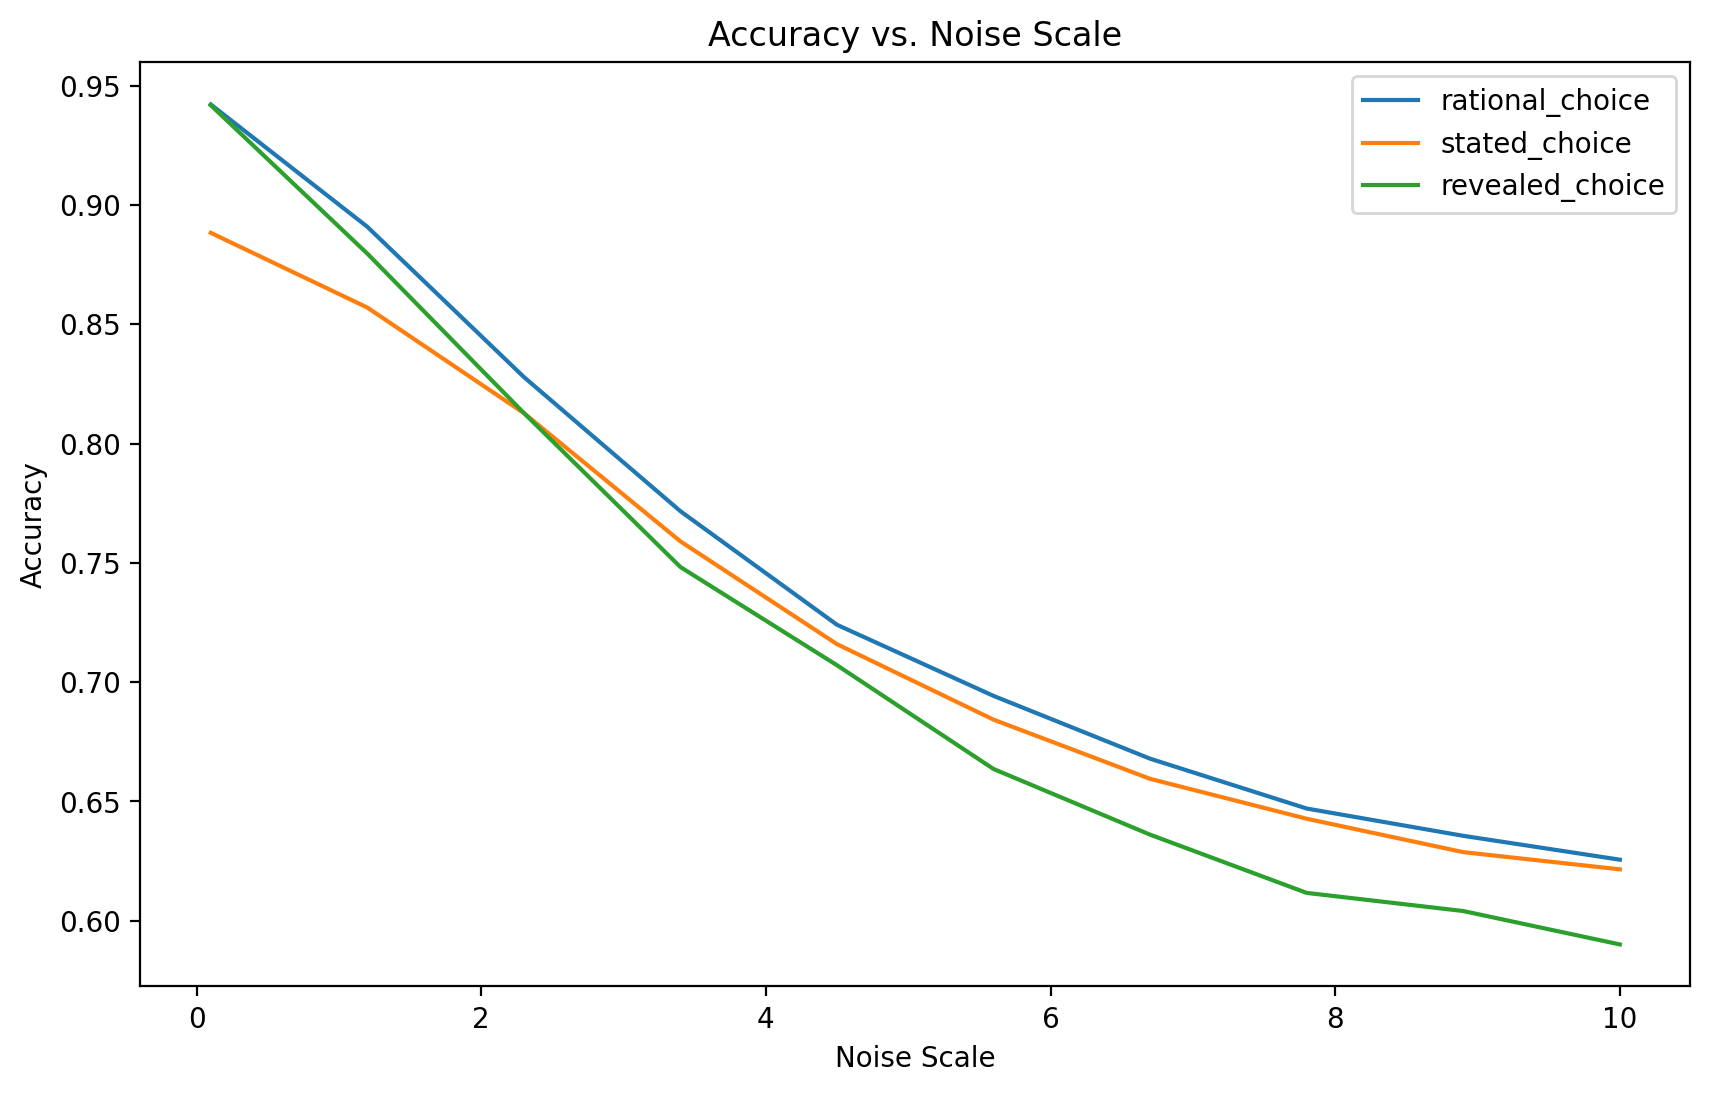

In [8]:
noise_scale_vec = np.linspace(0.1,10,10)
task12_n_repetitions = 50
task12_n_users = 20

## YOUR SOLUTION

labels = ['rational_choice', 'stated_choice', 'revealed_choice']
eval_label = 'revealed_choice'


def get_accs_for_scale(noise_scale):
    noisy_choice_env = NoisyBinaryChoiceEnvironment(
        noise_scale=noise_scale,
        stated_preference_bias=bias,
    )
    train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(
        n_users_train=task12_n_users
    )
    accuracies = {}
    for label in labels:
        model = sklearn.linear_model.LogisticRegression().fit(
            X=train_df[noisy_choice_env.feature_columns],
            y=train_df[label],
        )
        accuracies[label] = model.score(eval_df[noisy_choice_env.feature_columns], eval_df[eval_label])
    return accuracies
    
def plot_graph(labels_dfs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    
    for label, label_df in labels_dfs.items():
        plt.plot(label_df.index, label_df['accuracy'], label=label)
    plt.xlabel('Noise Scale')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Noise Scale')
    plt.legend(labels)
    plt.show()

bias = 1
noise_scale_graphs = {}
label_graph = { label: pd.DataFrame() for label in labels}
for noise_scale in noise_scale_vec:
    accuracies = { label: [] for label in labels}
    for _ in tqdm(range(task12_n_repetitions)):
        accuracies_for_n_repetitions = get_accs_for_scale(noise_scale)
        for label in labels:
            accuracies[label].append(accuracies_for_n_repetitions[label])
    accuracies_mean = {label: np.mean(accuracies[label]) for label in labels}
    for label in labels:
        label_graph[label].loc[noise_scale, 'accuracy'] = accuracies_mean[label]
    
plot_graph(label_graph)
# for label in labels:
#     plot_graph(label_graph[label], label)
    
        
        

Explain the results in detail. In your answer, relate to:
* Overall trends:
  * Are the lines increasing/decreasing/constant as a function of $\sigma$? Why?
* Relation between the lines:
  * Assuming that $y_\mathrm{rational}$ can't be measured in practice -
  Which of the remaining training labels ($y_\mathrm{stated}$, $y_\mathrm{revealed}$) is better when $\sigma\to 0$? which is better when $\sigma\to \infty$? Why?
  * If lines cross each other, when and why do they cross?
  * If lines coincide, when and why do they coincide?
* Range of values:
  * What is the range of accuracy values obtained?
  * How do they relate to upper/lower bounds of predictive performance?




🔵 **Answer**:

graph depicts how the accuracy of a prediction model (for y_rational, y_stated and y_revealed) changes as a function of noise magnitude (σ) in a logistic regression task.
1) Overall Trends:
- All Three models (represented by the three lines) show a similar trend. As the noise magnitude increases, the accuracy of the model decreases.
as noide magnitude increases, the preditability of the outcome decreases (it becomes harder to use a model infer minigful information as the noise becomes more significant)

2) Relation Between the Lines:
- When σ-> 0 (low noise) y_rational is closer in results to y_revealed, while y_stated performs the worst.
When there is very little noise we would prefer to use the revealed choice instead of the stated choice (which makes sense as the revealed choice will have low noise and therefore be more accurate)
- When σ-> ∞ (high noise) y_rational is closer in results to y_stated, while y_revealed performs the worst.
When there is a lot of noise we would prefer to use the stated choice instead of the revealed choice (which makes sense as the revealed choice will have high noise and therefore be less accurate to the rational choice, while the stated choice's difference from the rational choice will be less significant)

- The lines for y_stated y_revealed cross at moderate σ values (around 𝜎 = 2). This indicates the point where the noise increases too much for the model and the stated becomes the better option.
- The y_rational line and the y_revealed line coincide when σ is very low (best when it's 0) - which is when there is no noise and the revealed choice acts as the rational choice.
  The y_rational line and the y_stated line coincide when σ is very high (best when it's ∞) - which is when there is too much noise and the stated choice acts pretty close to the rational choice (as both get bad results compared to the revealed choice)
3)Range of Values:
- The accuracy values span from about 0.6 (at high σ) to nearly 0.95 (at low σ). This range reflects the predictive performance deterioration as noise increases.
- Upper Bound: The accuracy peaks at around 0.95 when σ=0, which represents the scenario with no noise, where the model perfectly captures the decision patterns.
- Lower Bound: The accuracy bottoms out at around 0.6 for all models when σ=10, which approaches random chance (if we would  continue with noise to inf we would get random choise which if around 50%) for a binary classification problem.

After describing your observations, try to answer the initial question: If users make consumption decisions in alignment with $y_\mathrm{revealed}$, which signal would be most effective for training the prediction model?



🔵 **Answer**:

(YOUR SOLUTION)

## Exercise 1.3: Evaluating Welfare

Plot a similar graph for the welfare metric you created in HW1:

$$
\mathrm{welfare}(f, S)=\frac{1}{|S|}\sum_{ (u,x) \in S } f(x) v_u(x)
$$

🔵 **Answer**:

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

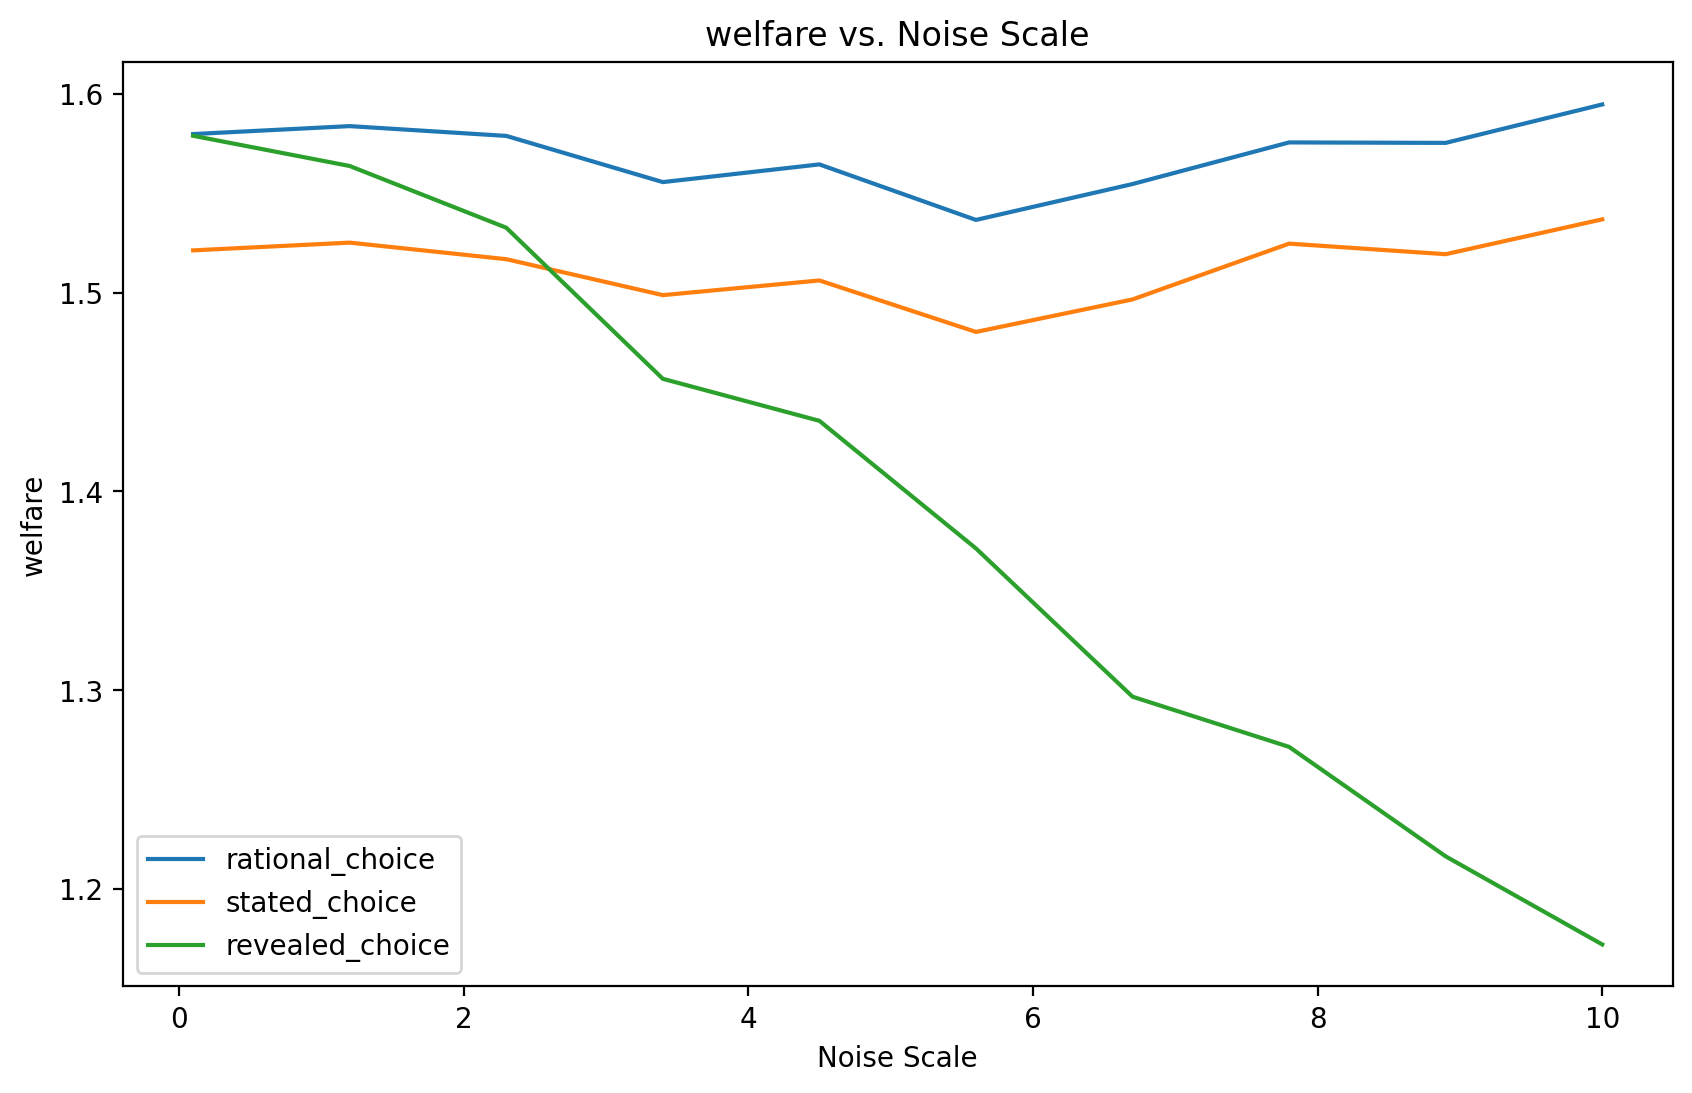

In [9]:
## YOUR SOLUTION

def welfare(f, eval_df, feature_columns, value_column):
    """
    Calculate the welfare for the given evaluation set

    Parameters
    ----------
    f : prediction function from pandas dataframe to {0,1}
    eval_df : pandas DataFrame, as returned by env.generate_train_eval_datasets
    feature_columns : names of feature columns (e.g `env.feature_columns`)
    value_column : name of value column (e.g `true_value`)

    Output
    ------
    welfare : float
    """
    ## YOUR SOLUTION
    eval_df['f_x'] = f(eval_df[feature_columns])
    eval_df['welfare'] = eval_df['f_x'] * eval_df[value_column]
    return eval_df['welfare'].mean()

def get_welfare_for_scale(noise_scale):
    noisy_choice_env = NoisyBinaryChoiceEnvironment(
        noise_scale=noise_scale,
        stated_preference_bias=bias,
    )
    train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(
        n_users_train=task12_n_users
    )
    welfares = {}
    for label in labels:
        model = sklearn.linear_model.LogisticRegression().fit(
            X=train_df[noisy_choice_env.feature_columns],
            y=train_df[label],
        )
        f = lambda x: model.predict(x)
        welfares[label] = welfare(f, eval_df, noisy_choice_env.feature_columns, 'true_value')
    return welfares
    
def plot_graph(labels_dfs):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    
    for label, label_df in labels_dfs.items():
        plt.plot(label_df.index, label_df['welfare'], label=label)
    plt.xlabel('Noise Scale')
    plt.ylabel('welfare')
    plt.title('welfare vs. Noise Scale')
    plt.legend(labels)
    plt.show()

bias = 1
noise_scale_graphs = {}
label_graph = { label: pd.DataFrame() for label in labels}
for noise_scale in noise_scale_vec:
    welfares = { label: [] for label in labels}
    for _ in tqdm(range(task12_n_repetitions)):
        welfares_for_n_repetitions = get_welfare_for_scale(noise_scale)
        for label in labels:
            welfares[label].append(welfares_for_n_repetitions[label])
    welfares_mean = {label: np.mean(welfares[label]) for label in labels}
    for label in labels:
        label_graph[label].loc[noise_scale, 'welfare'] = welfares_mean[label]
    
plot_graph(label_graph)

Explain your results:

🔵 **Answer**:

The plot shows how the welfare metric varies with the noise scale 𝜎 in the decision-making process for models trained based of y_rational, stated and revealed.

1) Overall Trends:
- Welfare of y_retional remains constantly the highest across all noise scales. 
it flows around 1.6 and seems that it dows not change with the noise scale - which makes sense as both the rational choice and the welfare function are not based on the noise.
- Welfare of y_stated is consistently remaining around 0.1 lower than the welfare of y_rational, while have the exact trend as the rational choice (floating around 1.5).
this makes sense as the stated choice is based on the rational choice (except for the bias which is constant through the noise scale) and therefore the welfare function will be similar to the rational choice.
- Welfare of y_revealed stated in the same position as the rational choice (no noise means that the revealed choice is the rational choice) and then starts to decrease as the noise increases.
as noise increases, the revealed preferences are increasingly corrupted, leading to suboptimal decisions and reduced welfare.
the decrease in welfare happens  because the model's accuracy decreases and therefore the welfare function will take less positive values into account and more negative values.

## Exercise 1.4: Welfare counter-example

**Assuming we use a linear classifer** (i.e. $f(x) = \mathrm{sign}(w^Tx + b)$)

Find a dataset for which the classifier which yields the best accuracy, does not promote optimal welfare. Explain your answer.

In your answer, you should provide:
* Items and features
* Utility function (utility doen't have to be linear)
* Present a classifier, and explain why it's optimal in terms of accuracy.
* Present another classifier which may have worse accuracy but better welfare.

Note: you can sketch a 1D/2D dataset using Power-Point (taking a screenshot), or through this website: https://app.diagrams.net/. Describe the solution in words below.

Attach the diagram inside a zip file together with your notebook when you submit your solution.

🔵 **Answer**:

General idea: One Item, Ten users. for users 1...9 the true value is -1. for user=10 the true value is 1000.
Meaning only one user holds any value in the item, and the others don't. However, the positive value for the one user far outweights the negative values all the other users have. The best classifier for this task would be to return False, e.g not to take, for each of the users, and get 90% accuracy. However the welfare will be 0.
Instead, a classifier that returns always True, e.g to take the item, will give a welfare of 1000 - 9*1 = 991.

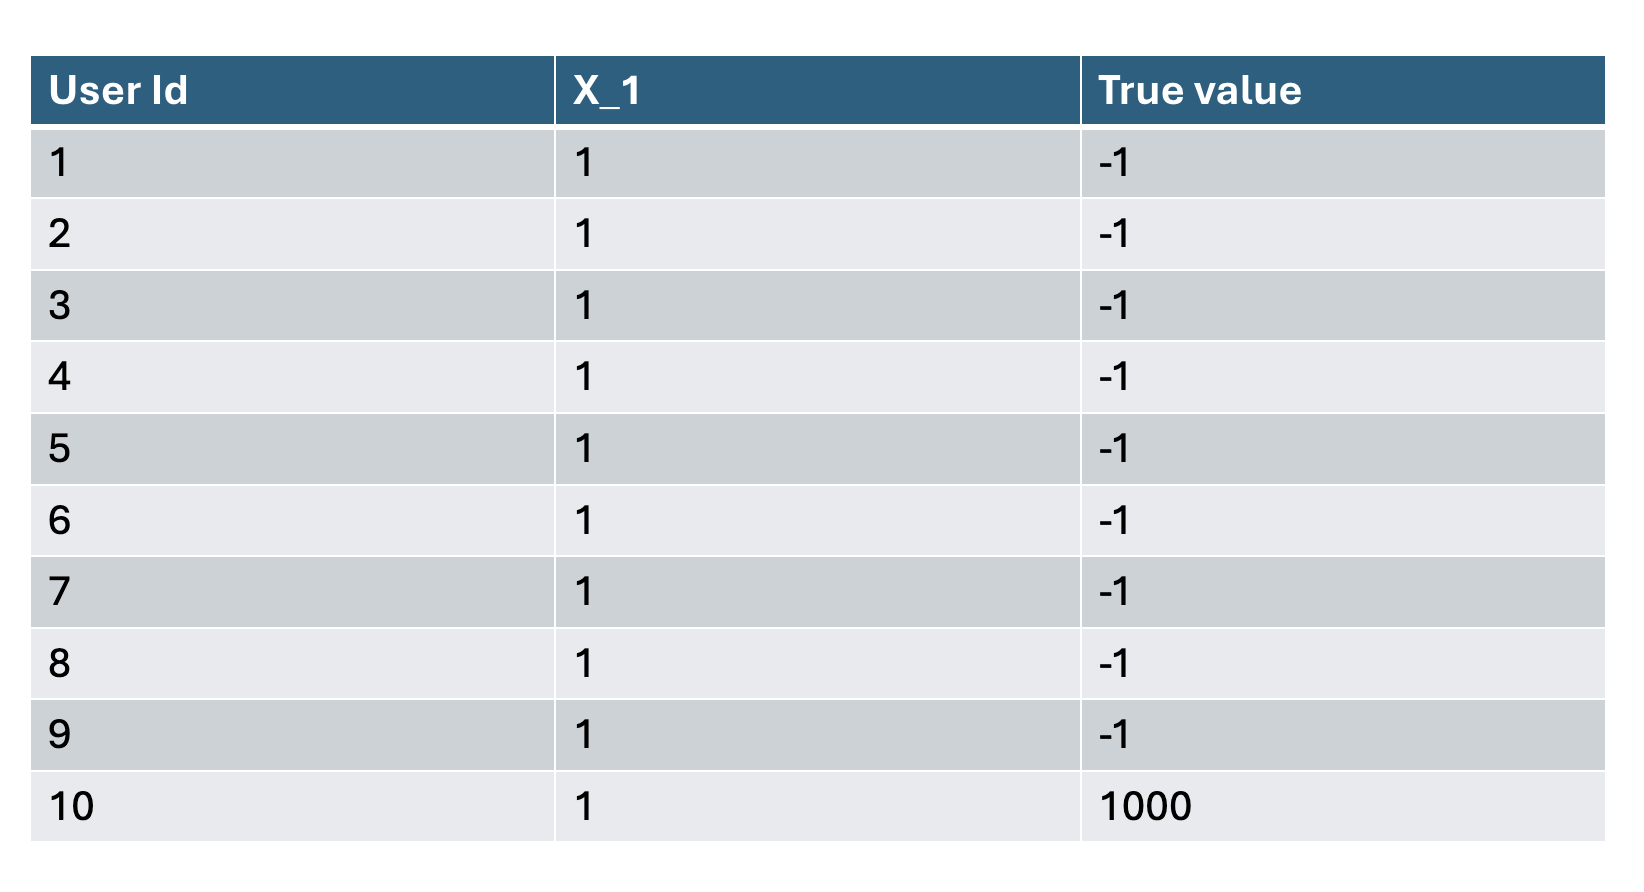

## Exercise 1.5: Mixed signals
Consider the following scenario:
You manage a recommendation system and have a dataset capturing the consumption choices ($y_\mathrm{revealed}$) of 10 users.
Since this is a small user base (even with multiple observations per user), you are offered the opportunity to gather additional survey data. The survey provides information about items and consumption decisions, assuming that users answer the survey according to $y_\mathrm{stated}$. You can survey up to 30 additional users. How many users should you include in the survey?

Assume a `NoisyBinaryChoiceEnvironment` with $\sigma=0.1$ and $b=1$. Support your claims with data, and explain your results.

Hints:
* The dataframes generated by `env.generate_train_eval_datasets` include a `user_id` column. Training set user IDs are numbered consecutively from `0` to `n_users_train-1` (inclusive).
* Evaluate survey sizes in increments of 5 by iterating over the vector provided below.
* To minimize estimation noise, repeat the experiment 100 times and average the results.

🔵 **Answer**:


  0%|          | 0/100 [00:00<?, ?it/s]

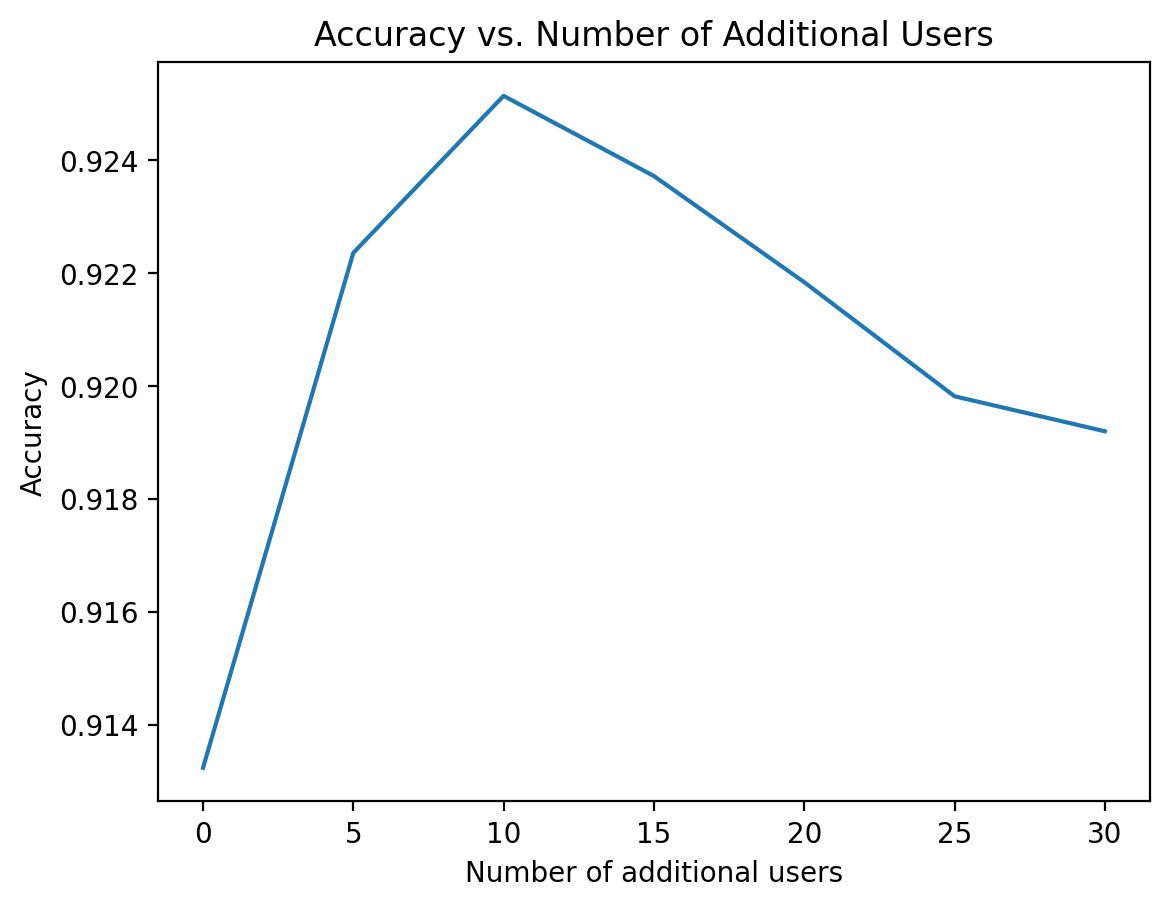

In [10]:
task_15_n_revealed = 10
task_15_n_additional_users_vec = np.arange(0,31,5)
task_15_n_repetitions = 100

## YOUR SOLUTION
env = NoisyBinaryChoiceEnvironment(
    noise_scale=0.1,
    stated_preference_bias=1,
)

users_number_to_accuracies_df = pd.DataFrame(index=task_15_n_additional_users_vec, columns=['accuracy'])
users_number_to_accuracies_df.index.name = 'n_additional_users'
users_number_to_accuracies_dict = {n: [] for n in task_15_n_additional_users_vec}
for _ in tqdm(range(task_15_n_repetitions)):
    first_users_train_df, users_eval_df = env.generate_train_eval_datasets(n_users_train=10)
    first_users_train_df['given_choice'] = first_users_train_df['revealed_choice']
    
    for n_additional_users in task_15_n_additional_users_vec:
        if n_additional_users > 0:
            users_additional_df, _ = env.generate_train_eval_datasets(n_users_train=n_additional_users)
            users_additional_df['given_choice'] = users_additional_df['stated_choice']
            users_train_df = pd.concat([first_users_train_df, users_additional_df])
        else:
            users_train_df = first_users_train_df
            
        model = sklearn.linear_model.LogisticRegression().fit(
            X=users_train_df[env.feature_columns],
            y=users_train_df['given_choice'],
        )   
        # We now check how good the model will be in predicting new users choices
        accuracy = (model.score(users_eval_df[env.feature_columns], users_eval_df['revealed_choice']))
        users_number_to_accuracies_dict[n_additional_users].append(accuracy)

for n_additional_users in task_15_n_additional_users_vec:
    users_number_to_accuracies_df.loc[n_additional_users, 'accuracy'] = np.mean(users_number_to_accuracies_dict[n_additional_users])
    
plt.plot(users_number_to_accuracies_df.index, users_number_to_accuracies_df['accuracy'])
plt.xlabel('Number of additional users')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Additional Users')
plt.show()

        
        




Explain your results:

🔵 **Answer**:

(YOUR SOLUTION)

Without additional computations, how would your answer change if $b=0$ or $b\to \infty$? If changes occur, explain how and why, providing justification for your reasoning.



🔵 **Answer**:

We see here the relationship between the number of additional users surveyed (up to 30) and the accuracy of a recommendation system (with combemation of rational and stated choices) in predicting the choices of new users. 
- Initial Increase in Accuracy:  as the number of additional users increases from 0 to around 10–15 users we see the accuracy of the model increases (even if this increase in very minor and unitially the accurcy is above 90%).
This is because the inclusion of more data (even from y_stated) reduces noise and provides a better training signal for the model. The additional survey data effectively enhances the model’s ability to generalize.
- at around 10 additional users, the accuracy reaches it's peak and then starts to decrease a little. this means that  indicating that this is the optimal range for balancing the benefits of more data with the noise introduced by the inherit bais of the stated responses.
- After including more than 15 additional users, the accuracy starts to decline. This could be due to the survey data's bais introduces noise that outweighs the benefits of the additional data.
  as y_stated is not as accurate as y_rational, the model may start to overfit to the noise in the additional data, leading to a decrease in accuracy.

# Task \#2: Irrational choice predition

## Introduction

In this task, we will evaluate the performance of a standard ("rational") prediction model when decision-makers are loss-averse.

In this section, users make decisions under uncertainty. Each user is associated with two utility functions, $u_a$ and $u_b$, and a probability parameter $p\in\left[0,1\right]$. The user's utility from consuming an item $x$ is:
- $u_a(x)\in\mathbb{R}$ with probability $p$, and
- $u_b(x)\in\mathbb{R}$ with probability $(1-p)$.

When user behavior is *rational*, the decision is made by comparing the *expected utility* of the two alternatives:

$$
y_\text{rational}=\begin{cases}
1&p \cdot u_a(x) + (1-p) \cdot u_b(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

When user decisions are subject to *behavioral bias*, choice deviates from the expected optiumum. In particular, we will focus on a setting where the users are *loss-averse*. In the spirit of [Prospect Theory](https://en.wikipedia.org/wiki/Prospect_theory), we assume there exist two functions $\pi, v$ such that the perceived value from consuming the item is:

$$
\begin{align}
V_{\pi, v}\left(x\right)
&=\sum_i \pi\left(p_i\right) v\left(u_i(x)\right)\\
&=\pi(p) \cdot v(u_a(x)) + \pi(1-p) \cdot v(u_b(x))
\end{align}
$$

The function $v$ captures the loss-aversion property, and it is s-shaped and asymmetrical. The function $\pi$ is a probability weighting function and captures the idea that people tend to overreact to small probability events, but underreact to large probabilities. Assuming $v(0)=0$, consumption decisions are made according to the following rule:

$$
y_\text{prospect}=\begin{cases}
1&V_{\pi,v}(x) \ge 0\\
0&\text{otherwise}
\end{cases}
$$

## Exercise 2.1: The functional form of $v$


The user valuation bias can be modeled using an S-shaped assymetrical function $v:\mathbb{R}\to\mathbb{R}$. Following [Maggi (2004, Section 4.1)](https://www.econstor.eu/bitstream/10419/87132/1/472515071.pdf), we assume that $v$ is a power S-shaped utility function, and its functional form is given by:


$$
v(u)=\begin{cases}
u^\alpha& u \ge 0 \\
-\gamma \left(-u\right)^\beta& u < 0
\end{cases}
$$

where $u=u(x)$ is the objective utility from consuming item $x$, and $0< \alpha \le \beta \le 1$, $\gamma\ge 1$ are constants.


**Implementation**

Implement the class `PowerLossAversion`. The class constructor will receive three scalar constants `alpha`, `beta`, `gamma`.  The `__call__` function will calculate $v(u)$ as defined above.

Hint: Make your code concise and more efficient by using numpy vectorized operations. Try to avoid explicit loops and `if` statements.

🔵 **Answer**:

In [11]:
class PowerLossAversion:
    """
    The power S-shaped utility function, as defined by Maggi (2014)
    """
    def __init__(self, alpha, beta, gamma):
        assert 0 < alpha <= 1
        assert 0 < beta <= 1
        assert alpha <= beta
        assert gamma >= 1
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def __call__(self, u: np.ndarray):
        """
        Compute the power S-shaped utility function for a vector of utilities.

        Parameters
        ----------
        u : ndarray of shape (n)

        Output
        ------
        v : ndarray of shape (n)
        """
        ## YOUR SOLUTION
        v = u.copy()
        v[u >= 0] = u[u >= 0] ** self.alpha
        v[u<0] = (-self.gamma) * (-u[u<0]) ** self.beta
        return v

Using the implementation above, plot the function $\nu$ for values of $u$ in the range $[-2,2]$, and for the given sets of parameters:

  1. $\left(\alpha_1, \beta_1, \gamma_1\right) = \left(1, 1, 1\right)$
  2. $\left(\alpha_2, \beta_2, \gamma_2\right) = \left(1, 1, 2.5\right)$
  3. $\left(\alpha_3, \beta_3, \gamma_3\right) = \left(0.88, 0.88, 2.5\right)$
  4. $\left(\alpha_4, \beta_4, \gamma_4\right) = \left(0.2, 0.88, 1.8\right)$

🔵 **Answer**:

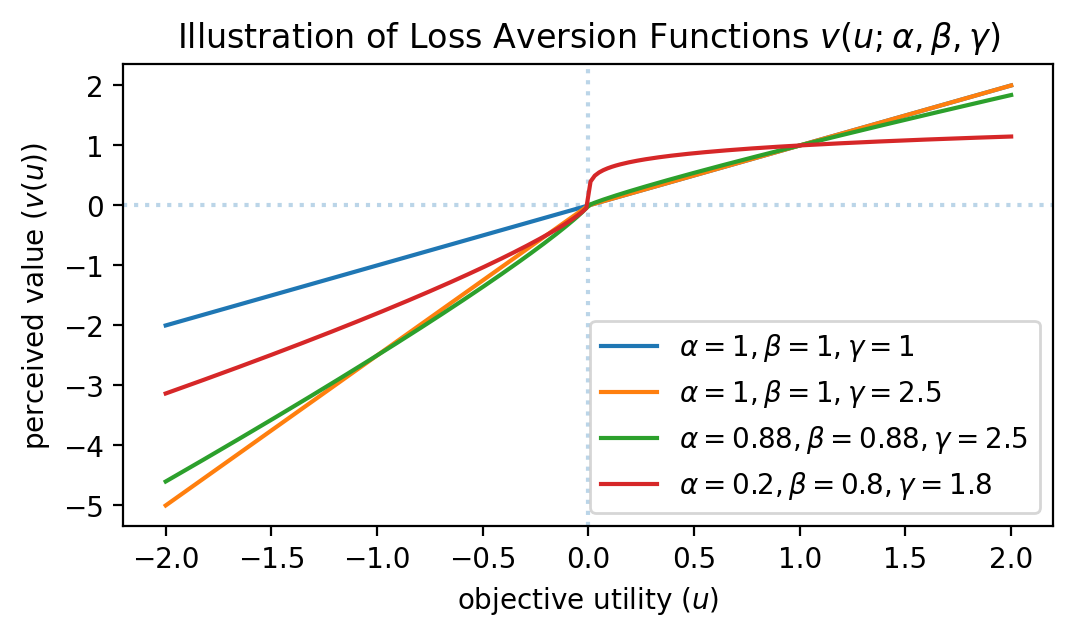

In [12]:
prospect_params_lst = [
    (1,1,1),
    (1,1,2.5),
    (0.88,0.88,2.5),
    (0.2,0.8,1.8),
]

fig,ax = plt.subplots(figsize=(6,3))

u_vec = np.linspace(-2,2,200)
for alpha, beta, gamma in prospect_params_lst:
    v = PowerLossAversion(alpha, beta, gamma)
    perceived_value = v(u_vec)
    ax.plot(
        u_vec,
        perceived_value,
        label=f'$\\alpha={alpha}, \\beta={beta}, \\gamma={gamma}$',
    )

ax.set_title('Illustration of Loss Aversion Functions $v(u; \\alpha, \\beta, \\gamma)$')
ax.set_xlabel('objective utility ($u$)')
ax.set_ylabel(r'perceived value ($v(u)$)')
ax.axhline(0,linestyle=':',zorder=-1,alpha=0.3)
ax.axvline(0,linestyle=':',zorder=-1,alpha=0.3)
ax.legend()

Given the results -

What type of behavior is characterized by the curve parametrized by $\left(\alpha, \beta, \gamma\right) = \left(1, 1, 1\right)$?

🔵 **Answer**:

The behavior characterized by the curve parameterized by (α,β,γ)=(1,1,1) represents linear utility without loss aversion.
- The curve is linear, meaning that the perceived value is equal to the objective utility.
  This means that the decision maker is indifferent to gains and losses and does not exhibit loss aversion (the person is completely rational).

- Such behavior aligns with the rational decision-making model, where users evaluate options purely based on expected utility without any distortions due to behavioral biases like loss aversion or probability weighting.


What is the interpretation of the parameter $\gamma$? Which behavioral traits are represented by high/low values of $\gamma$? What aspect of prospect theory does it correspond to?

🔵 **Answer**:

The parameter 𝛾 represents loss sensitivity in prospect theory, controlling the steepness of the value function in the negative section
(this while gamma does not effect  the positive section of the curve).

A higher 𝛾 indicates strong loss aversion, where individuals perceive losses more intensely and prioritize avoiding them, even at the cost of potential gains. 
on the other hand, a lower 𝛾 reflects reduced sensitivity to losses, leading to a more risk-taking behavior, where individuals focus more on potential rewards than avoiding losses (which is in our cases more close to the rational desition making).


What is the meaning of the parameters $\alpha,\beta$? What aspects of prospect theory do they correspond to?

🔵 **Answer**:

The parameters α and β in prospect theory represent the sensitivity to changes in value for gains and losses, respectively.
- α controls the steepness of the value function in the positive section, determining how individuals perceive gains.
- β controls the steepness of the value function in the negative section, determining how individuals perceive losses.
- A lower α (<1) indicates diminishing sensitivity, meaning that as gains increase, the perceived value of additional gains decreases (for example, gaining $100 feels less impactful after already gaining $1,000 in contrast to gaining 100$ before).
- a lower β (<1) reflects diminishing sensitivity to additional losses, meaning that small losses feel impactful, but the marginal effect of further losses diminishes.

These parameters reflect non-linear perceptions of value (as presented in the prospect theory) as people evaluate gains and losses differently and in a non-linear manner.


## Exercise 2.2: Simulating user behavior

**Example**

For the implementation of this behavioral model, we inherit from the `InnerProductTrueValueEnvironment` defined at the start of this notebook, and define the following abstract class:



In [13]:
class ProspectEnvironment(InnerProductTrueValueEnvironment):
    def _generate_user_attributes(self, n_users):
        """
        Generate latent parameters for users.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        """
        return np.stack(
            [
                np.random.normal(
                    loc=1,
                    scale=0.1,
                    size=(n_users, self.n_features),
                ),
                np.random.normal(
                    loc=-0.1,
                    scale=0.1,
                    size=(n_users, self.n_features),
                ),
            ],
            axis=0,
        )

We can inherit from these classes to create specific behavioral models. For example, here is a class which models unbiased decision making:

In [14]:
class RationalProspectEnvironmentExample(ProspectEnvironment):
    def __init__(self):
        p_a = 0.3
        self.p = [p_a, 1-p_a]
        super().__init__()

    def _choice(self, users, items):
        """
        Simulate choice

        Parameters
        ----------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        items : ndarray of shape (n_users, n_observations, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        # Calculate true value based on inner product
        u_a = self._true_value(users[0], items)
        u_b = self._true_value(users[1], items)
        return {
            'u_a': u_a,  # u_a(x)
            'u_b': u_b,  # u_b(x)
            'rational_choice': self.p[0]*u_a + self.p[1]*u_b >= 0,
        }

rational_env_example = RationalProspectEnvironmentExample()
rational_train_df, rational_eval_df = rational_env_example.generate_train_eval_datasets(n_users_train=100)
rational_train_df.sample(5)

,user_id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,u_a,u_b,rational_choice
98,9,-0.575144,0.516946,-0.253887,-1.141864,1.047971,-0.833836,-0.711554,0.368284,1.019190,-0.825065,1.595065,-0.274168,-0.211480,-2.877040,0.290593,0.390015,-2.265566,-0.005934,False
652,65,0.571372,-0.423583,0.262365,-0.573814,-0.797834,-0.047865,-0.009224,0.893873,0.366287,1.057714,0.913678,0.469386,-0.256376,-0.319425,-0.150716,0.296068,2.206495,-0.300364,True
778,77,-1.705635,-1.165118,-1.630676,1.673759,0.851508,-0.011414,0.260179,-0.333926,0.454920,2.128189,1.029467,-0.090651,-0.891724,-0.116653,0.369099,0.839127,2.250782,0.117201,True
235,23,-1.897820,0.876047,-0.125794,0.120856,0.384743,-0.169827,-0.355006,-0.063107,1.422811,0.286492,-2.354042,0.914681,0.340724,0.293414,0.654814,-0.968589,-0.735534,0.191976,False
117,11,-0.433238,-1.504717,-0.482059,0.119553,0.620939,0.356559,-1.174757,-0.197884,-0.282718,1.456550,-0.385947,0.176873,-0.471081,-0.854886,1.574232,-1.352473,-2.585638,-0.155737,False


**Implementation**

Based on the example above, implement the `BehavioralProspectEnvironment` class for simulating choice in a behavioral environment:
* Class should inherit from `ProspectEnvironment`
* Prospect value function $v(u)$ and a probability weighting function $\pi(p)$ should be given in the class constructor.
* Value of $p$ should be constant: $p=0.3$
* Implement the binary choice inside the `_choice` function. Function returns a dictionary mapping column names to numpy arrays containing their contents (see example above).

🔵 **Answer**:

In [15]:
## YOUR SOLUTION
class BehavioralProspectEnvironment(ProspectEnvironment):
    def __init__(self, v_prospect_func, pi_prob_weigh_func):
        p_a = 0.3
        self.p = [p_a, 1-p_a]
        self.v_prospect_func = v_prospect_func
        self.pi_prob_weigh_func = pi_prob_weigh_func
        self.weighted_p = [pi_prob_weigh_func(self.p[0]), pi_prob_weigh_func(1-self.p[0])]
        super().__init__()

    def _choice(self, users, items):
        """
        Simulate choice

        Parameters
        ----------
        users : ndarray of shape (n_outcomes, n_users, n_features)
        items : ndarray of shape (n_users, n_observations, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        # Calculate true value based on inner product
        u_a = self._true_value(users[0], items)
        u_b = self._true_value(users[1], items)
        behavioral_choice = (self.weighted_p[0]*self.v_prospect_func(u_a) + self.weighted_p[1]*self.v_prospect_func(u_b)) >= 0
        return {
            'u_a': u_a,  # u_a(x)
            'u_b': u_b,  # u_b(x)
            'behavioral_choice': behavioral_choice,
        }
        
    def set_observation_per_user(self, observations_per_user):
        self.observations_per_user = observations_per_user

## Exercise 2.3: Predicting under behavioral bias



For each set of behavioral parameters $\left(\alpha_1, \beta_1, \gamma_1\right),\dots,\left(\alpha_4, \beta_4, \gamma_4\right)$ given above, and for a neutral probability weighting ($\pi(p)=p$), train and evaluate a Logistic Regression model on data generated by the corresponding `BehavioralProspectEnvironment`, with `n_users=100`.

Report evaluation set accuracy for each set of parameters, averaged over 10 repetitions of the simulation.

🔵 **Answer**:

In [16]:
task_2_3_n_repetitions = 10
task_2_3_n_users = 100

## YOUR SOLUTION
prospect_params_lst = [
    (1,1,1),
    (1,1,2.5),
    (0.88,0.88,2.5),
    (0.2,0.8,1.8),
] 
for alpha, beta, gamma in prospect_params_lst:
    v = PowerLossAversion(alpha, beta, gamma)
    pi = lambda p: p
    behavioral_env = BehavioralProspectEnvironment(v, pi)
    train_df, eval_df = behavioral_env.generate_train_eval_datasets(n_users_train=task_2_3_n_users)
    accuracies = []
    for _ in tqdm(range(task_2_3_n_repetitions)):
        model = sklearn.linear_model.LogisticRegression().fit(
            X=train_df[behavioral_env.feature_columns],
            y=train_df['behavioral_choice'],
        )
        accuracies.append(model.score(eval_df[behavioral_env.feature_columns], eval_df['behavioral_choice']))
    print(f'alpha={alpha}, beta={beta}, gamma={gamma}: {np.mean(accuracies)}')

  0%|          | 0/10 [00:00<?, ?it/s]

alpha=1, beta=1, gamma=1: 0.9019999999999999


  0%|          | 0/10 [00:00<?, ?it/s]

alpha=1, beta=1, gamma=2.5: 0.796


  0%|          | 0/10 [00:00<?, ?it/s]

alpha=0.88, beta=0.88, gamma=2.5: 0.732


  0%|          | 0/10 [00:00<?, ?it/s]

alpha=0.2, beta=0.8, gamma=1.8: 0.71


Plot a line graph representing the accuracy, for fixed $\alpha=\beta=1$ and variable $\gamma\in[1,5]$. Repeat each simulation 10 times for each value of $\gamma$, and use the average value for the plot.

🔵 **Answer**:

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

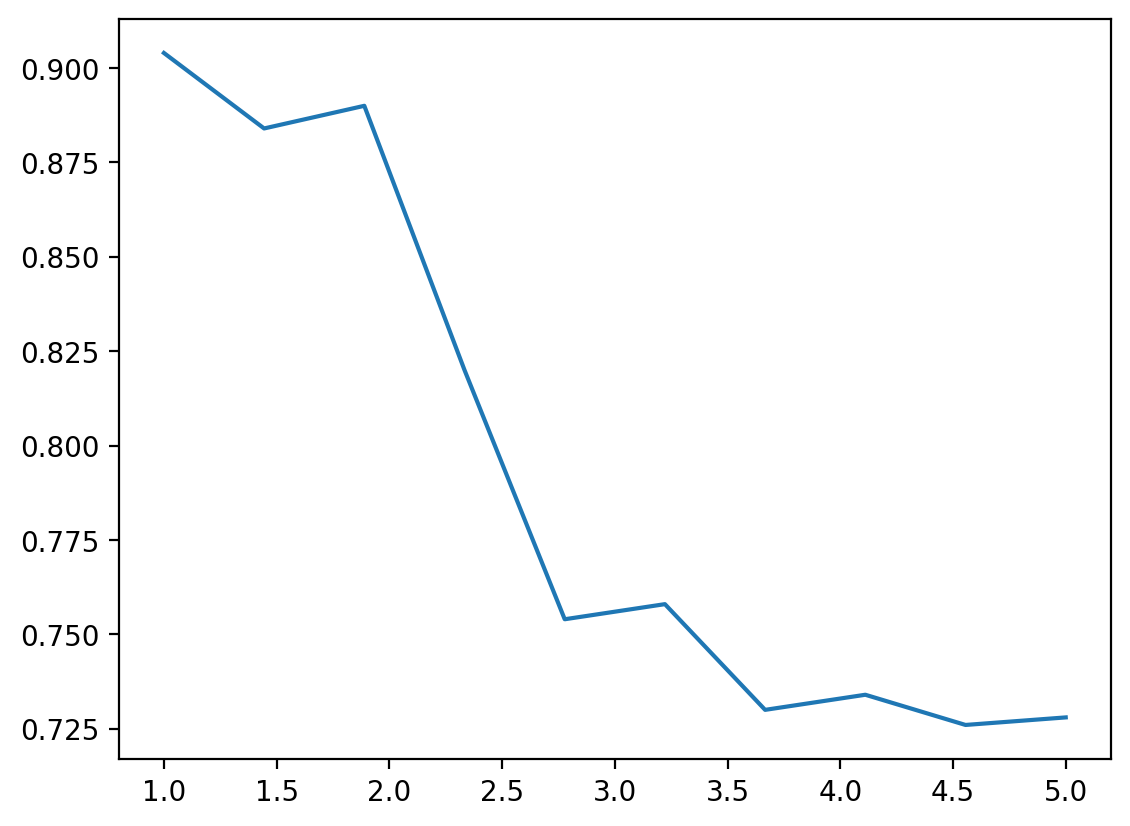

In [17]:
alpha = 1
beta = 1
gamma_vec = np.linspace(1,5,10)

## YOUR SOLUTION
n_repetitions = 10
gamma_to_accuracy = pd.DataFrame()
for gamma in gamma_vec:
    for _ in tqdm(range(n_repetitions)):
        v = PowerLossAversion(alpha, beta, gamma)
        pi = lambda p: p
        behavioral_env = BehavioralProspectEnvironment(v, pi)
        train_df, eval_df = behavioral_env.generate_train_eval_datasets(n_users_train=task_2_3_n_users)
        accuracies = []
        for _ in range(task_2_3_n_repetitions):
            model = sklearn.linear_model.LogisticRegression().fit(
                X=train_df[behavioral_env.feature_columns],
                y=train_df['behavioral_choice'],
            )
            accuracies.append(model.score(eval_df[behavioral_env.feature_columns], eval_df['behavioral_choice']))
    gamma_to_accuracy.loc[gamma, 'accuracy'] = np.mean(accuracies)

plt.plot(gamma_to_accuracy.index, gamma_to_accuracy['accuracy'])

Explain the results:

🔵 **Answer**:

the graph above shows the average accuracy of the model (logistic regression) for different values of gamma while alpha and beta are fixed.
- As gamma increases, the model's accuracy decreases. while initially (gamma=1) the accuracy is the highest (around 0.9) and progressively decreases as gamma increases until it drops to around 0.725 when gamma is 5.
- Generally we see a trend that larger Gamma values (loss sensetivity) makes people irrational and oversensitive to loss.
   At γ=1, users are moderately sensitive to losses, and their behavior remains relatively rational and predictable (accuracy is high as model can predict their consitent behavior and patterns).
   As γ increases, users become more loss-averse and irrational, leading to more unpredictable behavior and lower model accuracy.
- As taught in class, loss aversion can lead to suboptimal decisions, as individuals may prioritize avoiding losses over maximizing gains, leading to irrational and inconsistent behavior.
  this behavior is reflected in the model's lower accuracy as it becomes harder to predict the user's choices.

Similarly, plot two lines representing the accuracy, for fixed $\gamma=\{1,2\}$ and variable $\alpha=\beta\in[0.4,1]$. Repeat each simulation 10 times for each value of $\gamma$, and average results.

🔵 **Answer**:

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

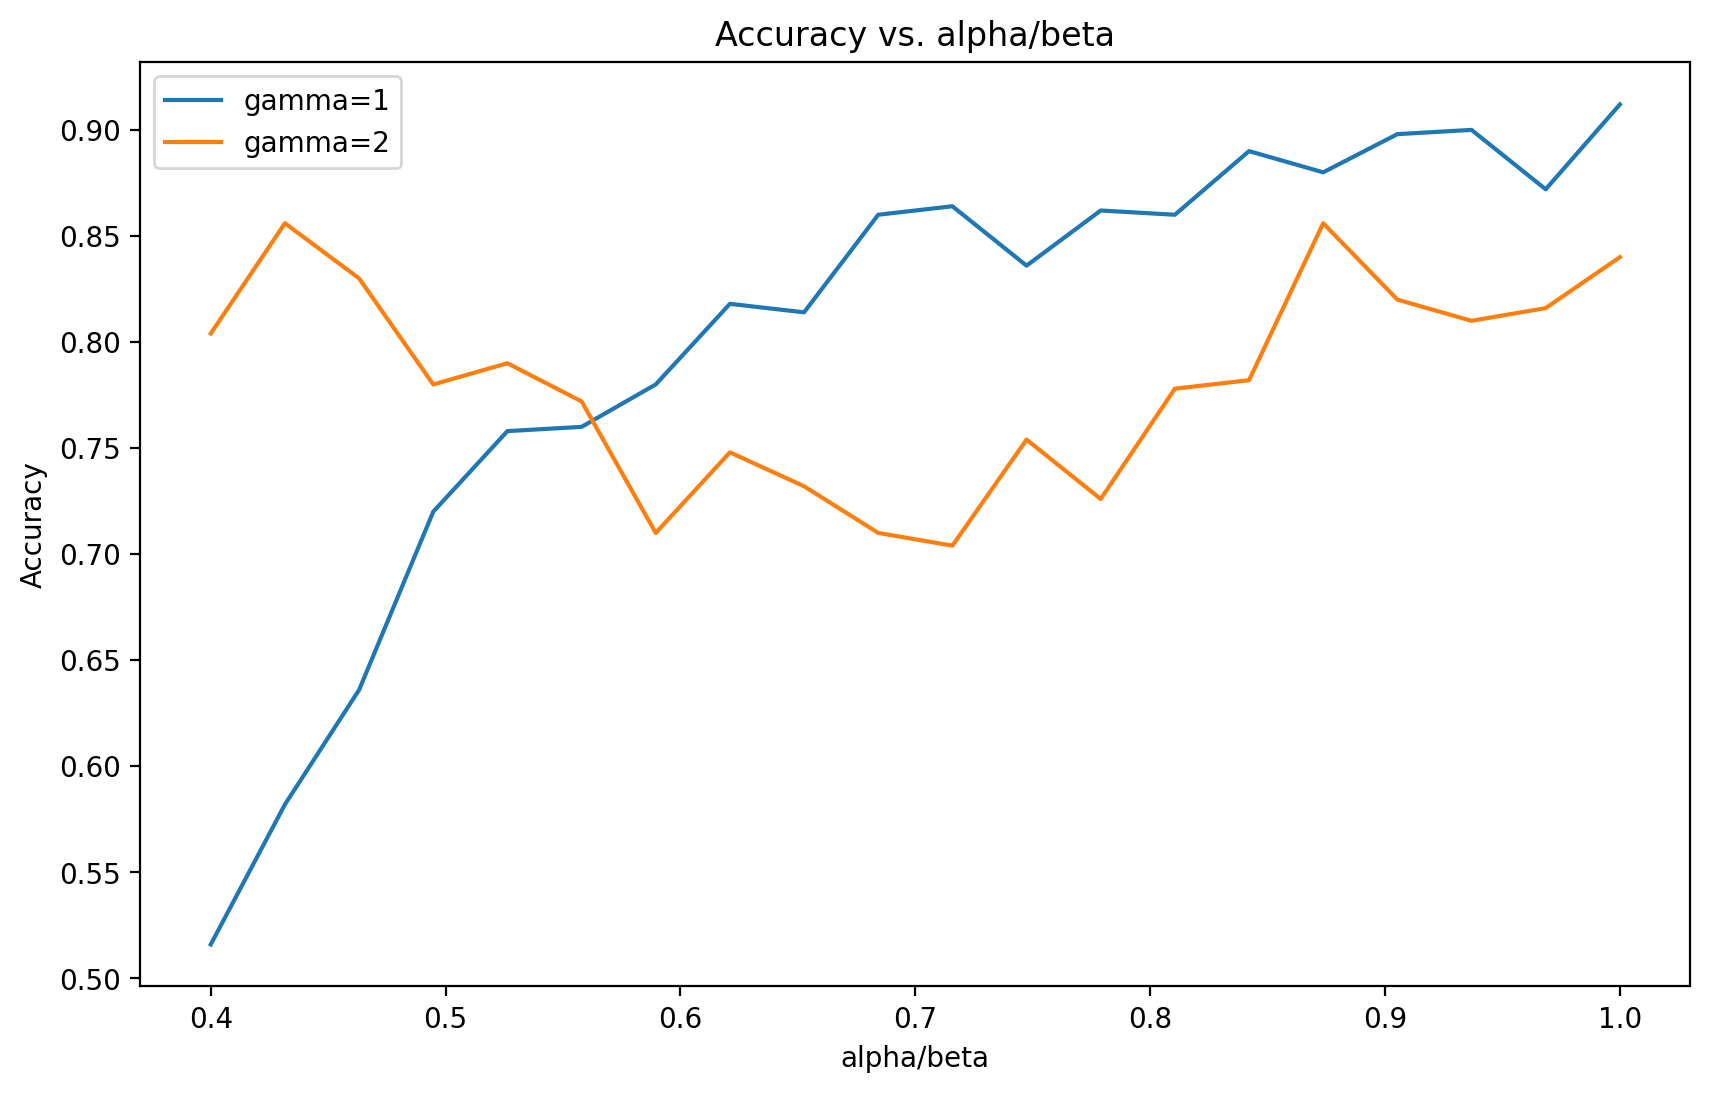

In [18]:
alphabeta_vec = np.linspace(0.4,1,20)
gamma=[1,2]

## YOUR SOLUTION
allphabet_to_accuracy = {gam: pd.DataFrame() for gam in gamma}

for alpha in alphabeta_vec:
    for gam in gamma:
        beta = alpha
        v = PowerLossAversion(alpha, beta, gam)
        pi = lambda p: p
        behavioral_env = BehavioralProspectEnvironment(v, pi)
        train_df, eval_df = behavioral_env.generate_train_eval_datasets(n_users_train=task_2_3_n_users)
        accuracies = []
        for _ in tqdm(range(task_2_3_n_repetitions)):
            model = sklearn.linear_model.LogisticRegression().fit(
                X=train_df[behavioral_env.feature_columns],
                y=train_df['behavioral_choice'],
            )
            accuracies.append(model.score(eval_df[behavioral_env.feature_columns], eval_df['behavioral_choice']))
        accuracy_mean = np.mean(accuracies)
        allphabet_to_accuracy[gam].loc[alpha, 'accuracy'] = accuracy_mean

# Plot the alpha-beta vs. accuracy graph, each line represents a different gamma value
plt.figure(figsize=(10, 6))
for gam in gamma:
    plt.plot(allphabet_to_accuracy[gam].index, allphabet_to_accuracy[gam]['accuracy'], label=f'gamma={gam}')
plt.xlabel('alpha/beta')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. alpha/beta')
plt.legend()
plt.show()





Explain your results:

🔵 **Answer**:

For gamma=1: There is a semetry between the positive and negative values, as gamma=1 and alpha=beta. The higher alpha and betta are, the more "decisive" the user is, as he is more likely to have strong positive (very high v(x) value) or negative (very low negative v(x) value) true value for a given item. This makes the prediction easier as the samples are more easily seperated.

For Gamma=2: We see interesting behavior, here the increase of alpha/beta doesn't increase the predictor's accuracy.


What can we conclude about the performance of a logistic regression classifier on behavioral data? What can explain the above observations?

🔵 **Answer**:

We can conclude 2 main points:
- The first is that irrational loss iversion makes the classification task of loggistic regression classifier harder, as the  function's S "shape" is asymetric, in contrast to a segmoid. And so the higher the gamma values are, the less the accuracy is.
- Also, in general the more decisive user's are, the easier it is to classify. the lower the alpha/beta values are, the more "muted" the preferences of the users are, and the harder is the prediction task.

# Task 3: Exploratory Analysis (Open-Ended)

We present three open-ended questions. Please choose one of them and answer in detail. **Bonus will be given for solving more than one question**.

This task is exploratory, and we encourage you to try different and creative approaches to solve it. In your answers, you should design and run appropriate experiment(s) - state your hypotheses, show plots that support your claim, and explain them.



## Option 1: Exploratory analysis (for Task \#1)


Looking at both measures (accuracy and welfare), try to vary the parameters of the experiment (\#users, \#items, \#features, environment parameters, etc.) in ways that show interesting trends. Explain your results in detail and support your claims.


In [19]:
## YOUR SOLUTION

def welfare(f, eval_df, feature_columns, value_column):
    """
    Calculate the welfare for the given evaluation set

    Parameters
    ----------
    f : prediction function from pandas dataframe to {0,1}
    eval_df : pandas DataFrame, as returned by env.generate_train_eval_datasets
    feature_columns : names of feature columns (e.g `env.feature_columns`)
    value_column : name of value column (e.g `true_value`)

    Output
    ------
    welfare : float
    """
    ## YOUR SOLUTION
    eval_df['f_x'] = f(eval_df[feature_columns])
    eval_df['welfare'] = eval_df['f_x'] * eval_df[value_column]
    return eval_df['welfare'].mean()

def get_welfare(train_users_num=20, noise_scale=1, bias=1, eval_users_num=None, items_num=None, features_num=None):
    noisy_choice_env = NoisyBinaryChoiceEnvironment(
        noise_scale=noise_scale,
        stated_preference_bias=bias,
    )
    if items_num is not None:
        noisy_choice_env.observations_per_user = items_num
    if features_num is not None:
        noisy_choice_env.n_features = features_num
    if eval_users_num is not None:
        noisy_choice_env.n_users_eval = eval_users_num
    train_df, eval_df = noisy_choice_env.generate_train_eval_datasets(
        n_users_train=train_users_num
    )
    welfares = {}
    accuracies = {}
    for label in labels:
        model = sklearn.linear_model.LogisticRegression().fit(
            X=train_df[noisy_choice_env.feature_columns],
            y=train_df[label],
        )
        f = lambda x: model.predict(x)
        accuracies[label] = model.score(eval_df[noisy_choice_env.feature_columns], eval_df['revealed_choice'])
        welfares[label] = welfare(f, eval_df, noisy_choice_env.feature_columns, 'true_value')
    return welfares, accuracies
    
def plot_graph(labels_dfs, label_name, param_name):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    
    for label, label_df in labels_dfs.items():
        plt.plot(label_df.index, label_df[label_name], label=label)
    plt.xlabel(param_name)
    plt.ylabel(label_name)
    plt.title(f'{label_name} vs. {param_name}')
    plt.legend(labels)
    plt.show()

def create_graph_for_welfare_param(param_vec, param_name):
    label_graph_welfare = { label: pd.DataFrame() for label in labels}
    label_graph_accuracy = { label: pd.DataFrame() for label in labels}
    for param in param_vec:
        welfares = { label: [] for label in labels}
        accuracies = { label: [] for label in labels}
        for _ in tqdm(range(50)):
            welfares_for_n_repetitions, accuracies_for_n_repetitions = get_welfare(**{param_name: param})
            for label in labels:
                welfares[label].append(welfares_for_n_repetitions[label])
                accuracies[label].append(accuracies_for_n_repetitions[label])
        welfares_mean = {label: np.mean(welfares[label]) for label in labels}
        accuracies_mean = {label: np.mean(accuracies[label]) for label in labels}
        for label in labels:
            label_graph_welfare[label].loc[param, 'welfare'] = welfares_mean[label]
            label_graph_accuracy[label].loc[param, 'accuracy'] = accuracies_mean[label]
    plot_graph(label_graph_welfare, 'welfare', param_name)
    plot_graph(label_graph_accuracy, 'accuracy', param_name)



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

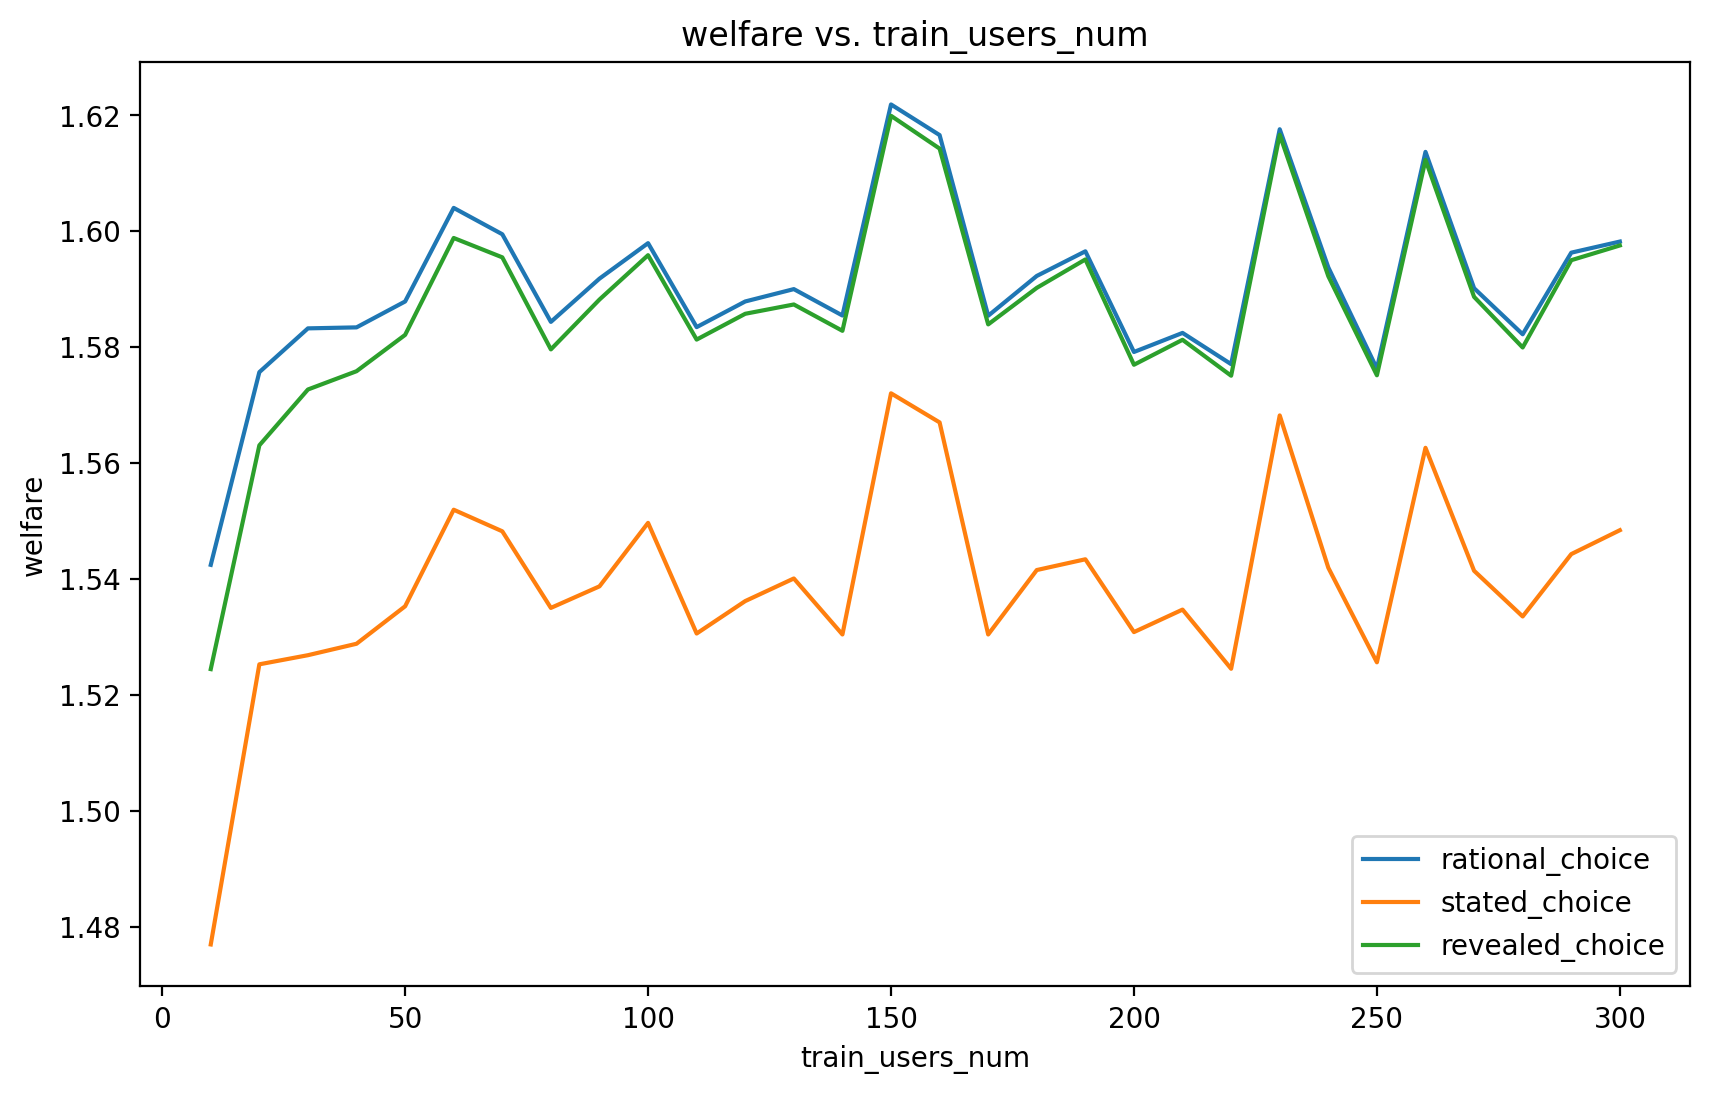

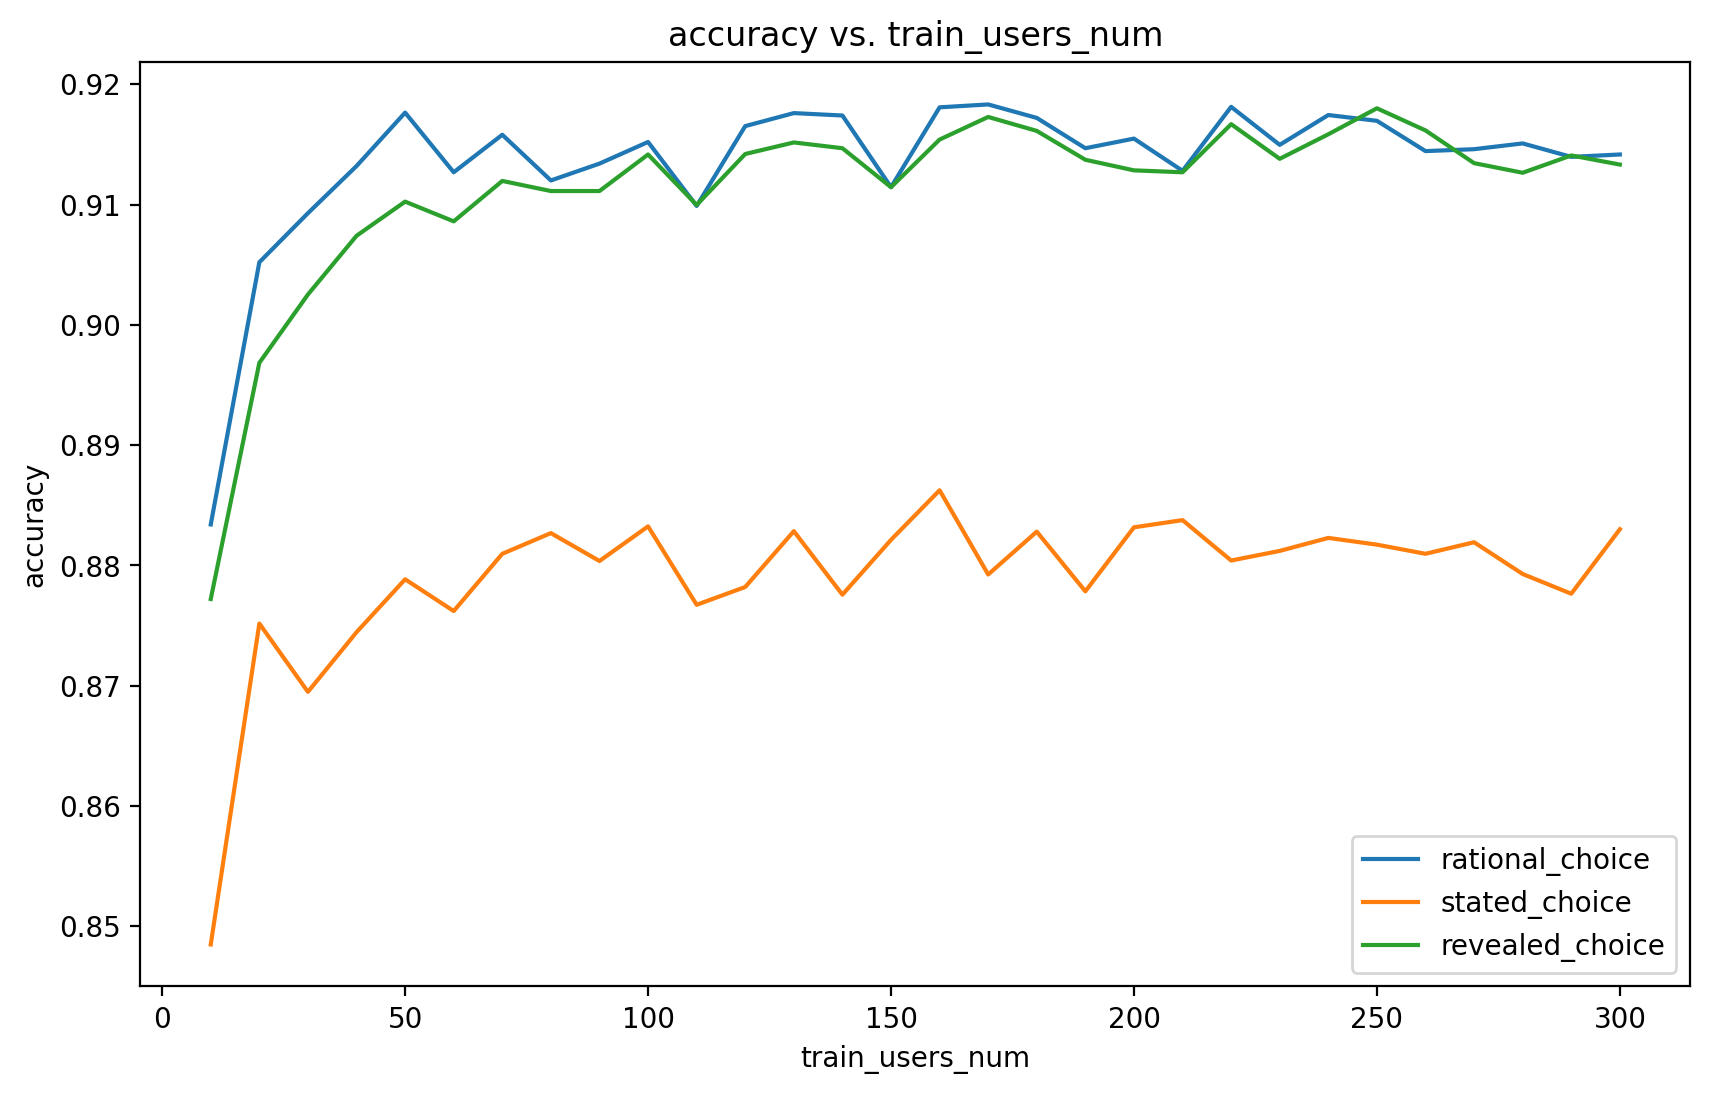

In [20]:
users_num_vec = np.arange(10, 301, 10)
create_graph_for_welfare_param(users_num_vec, 'train_users_num')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

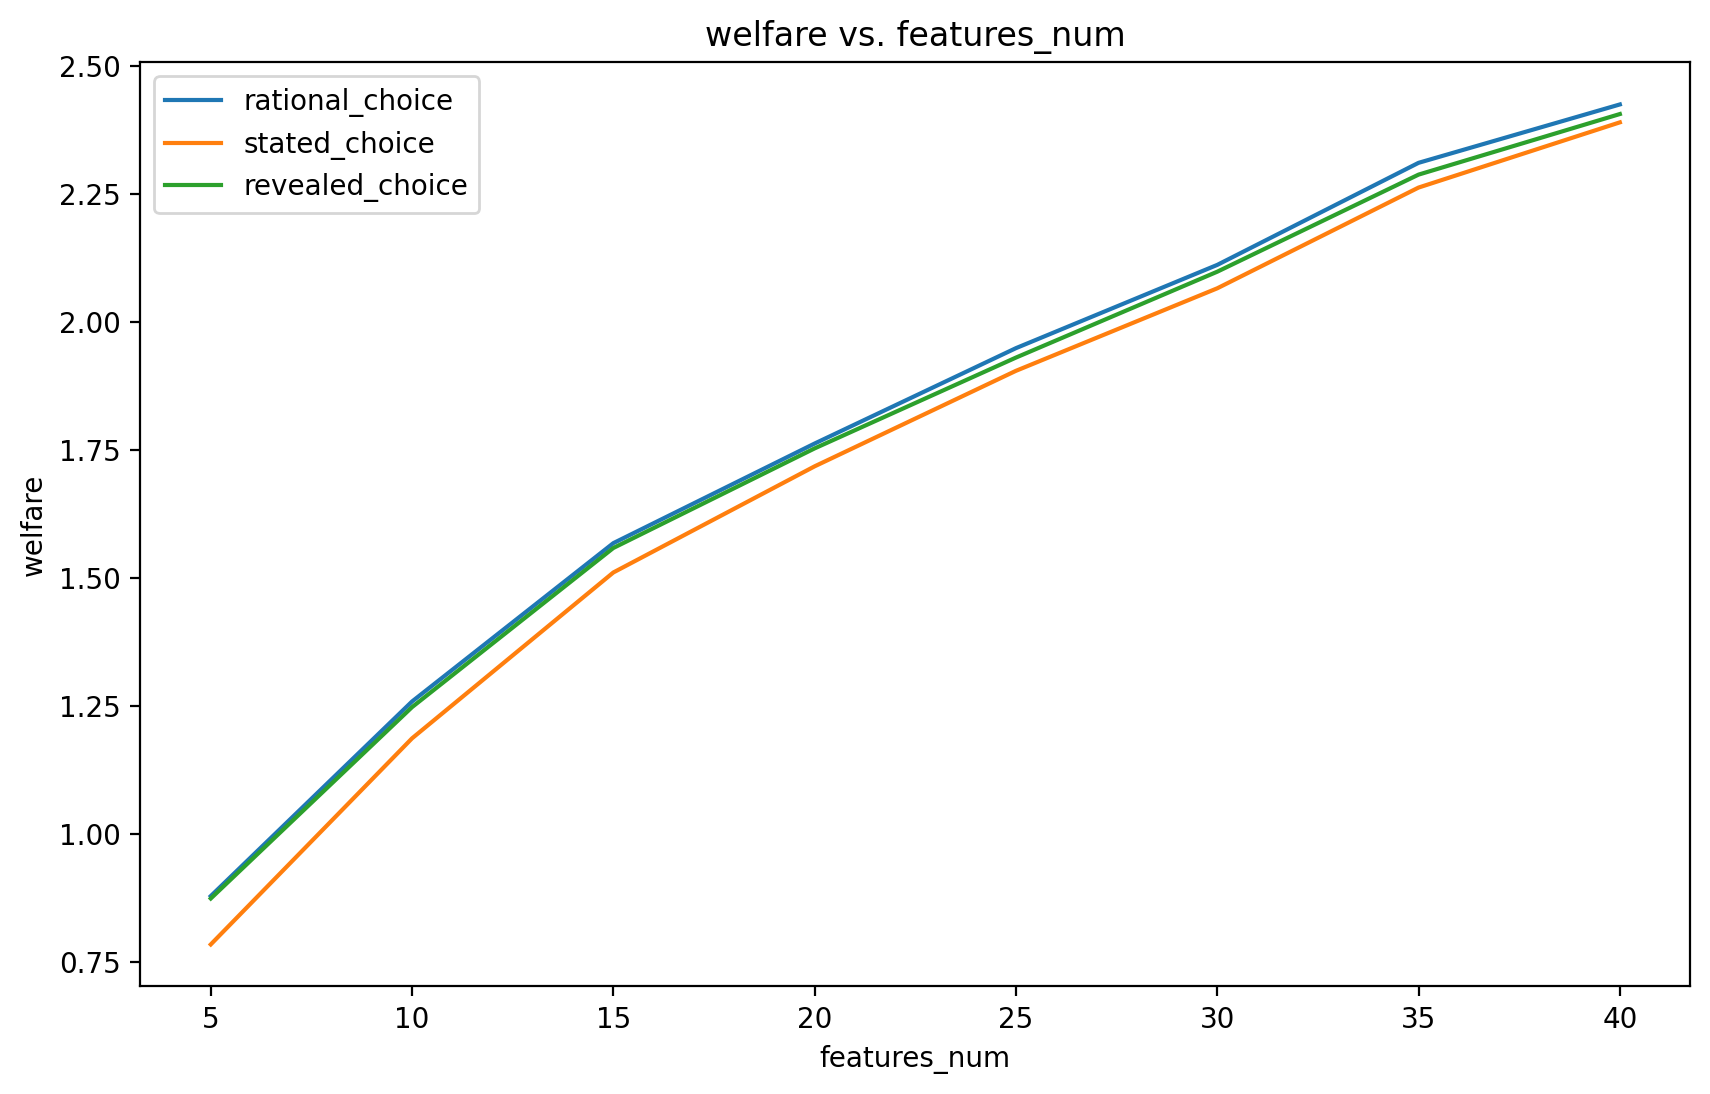

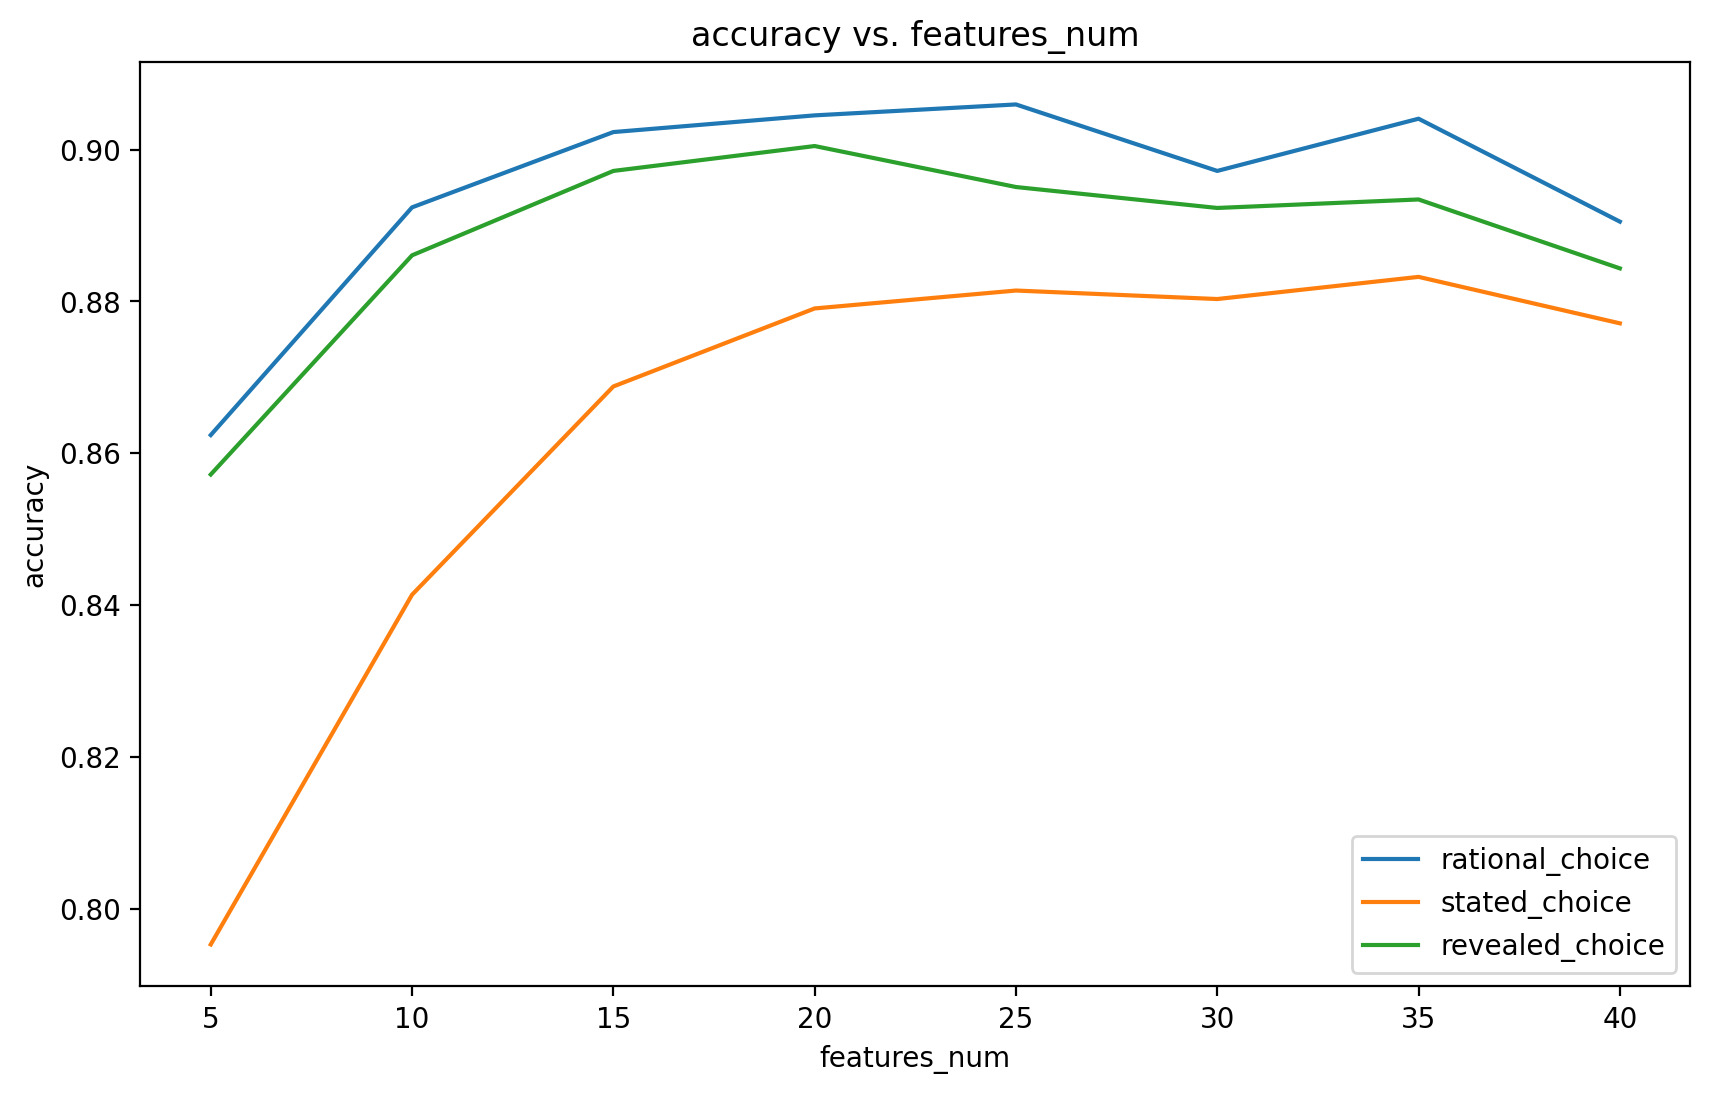

In [21]:
n_features_vec = np.arange(5, 41, 5)
create_graph_for_welfare_param(n_features_vec, 'features_num')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

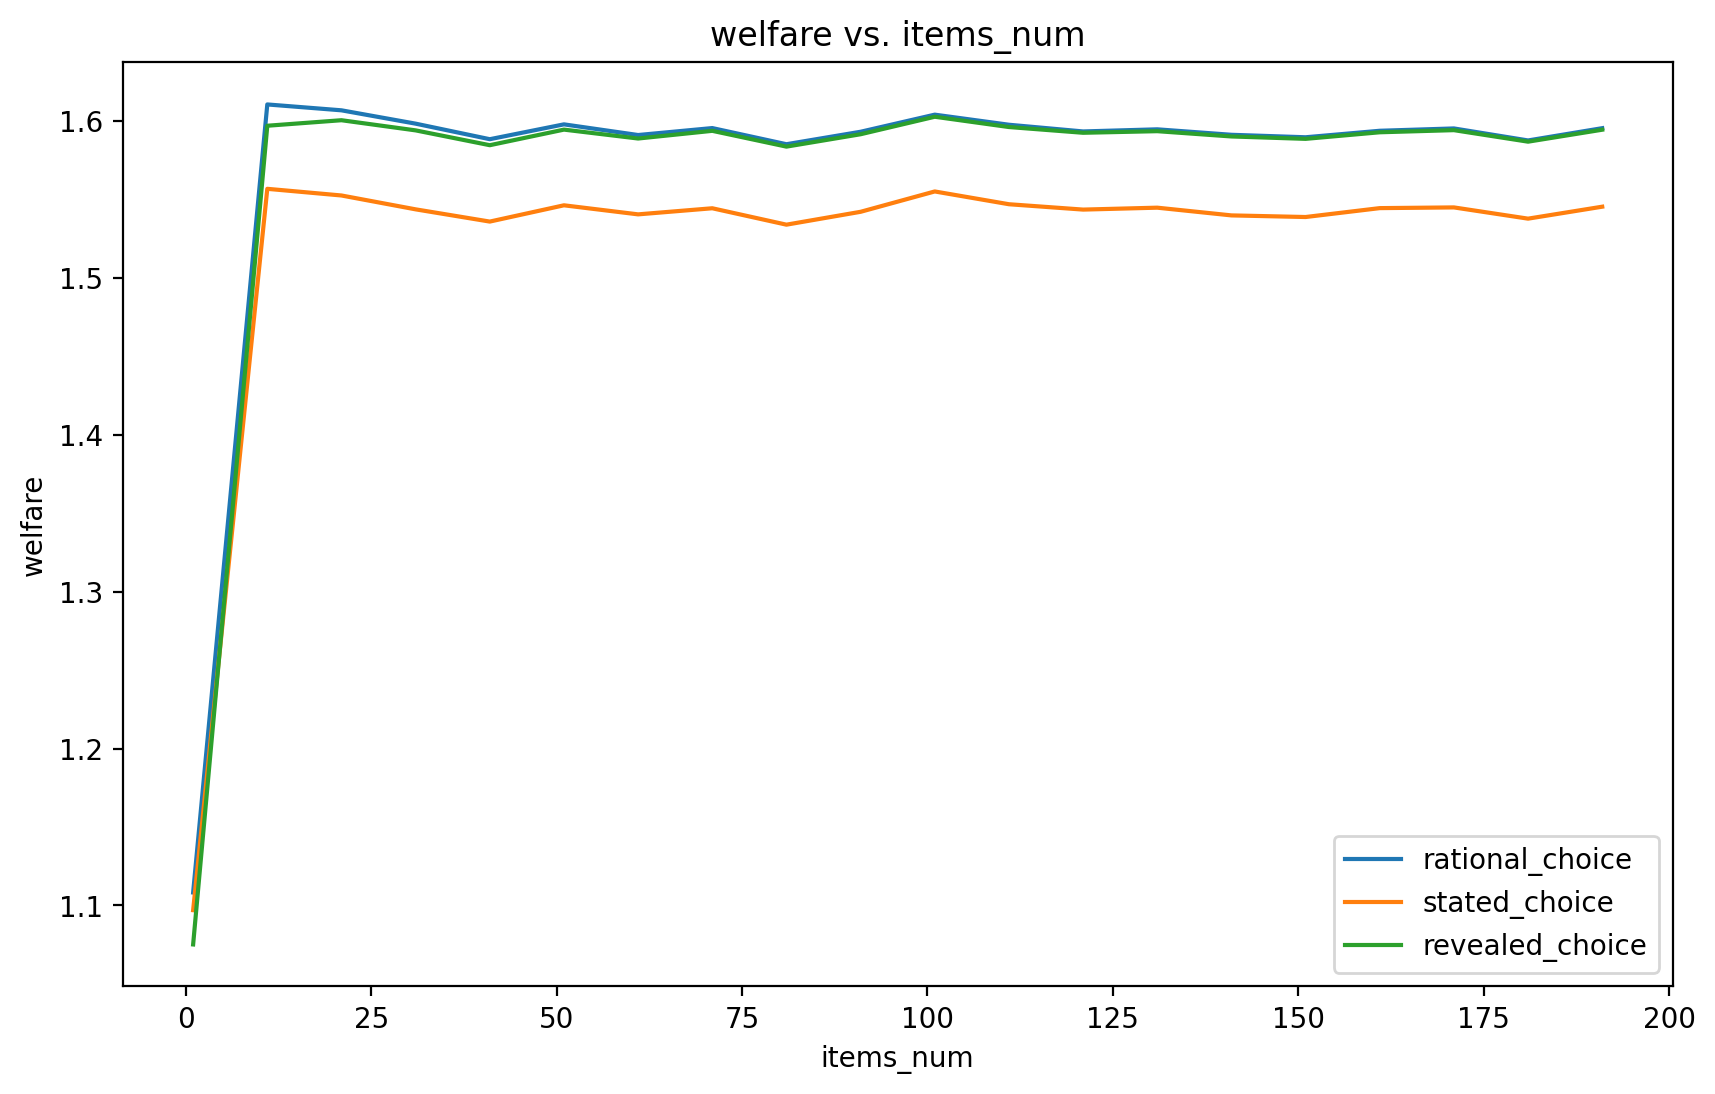

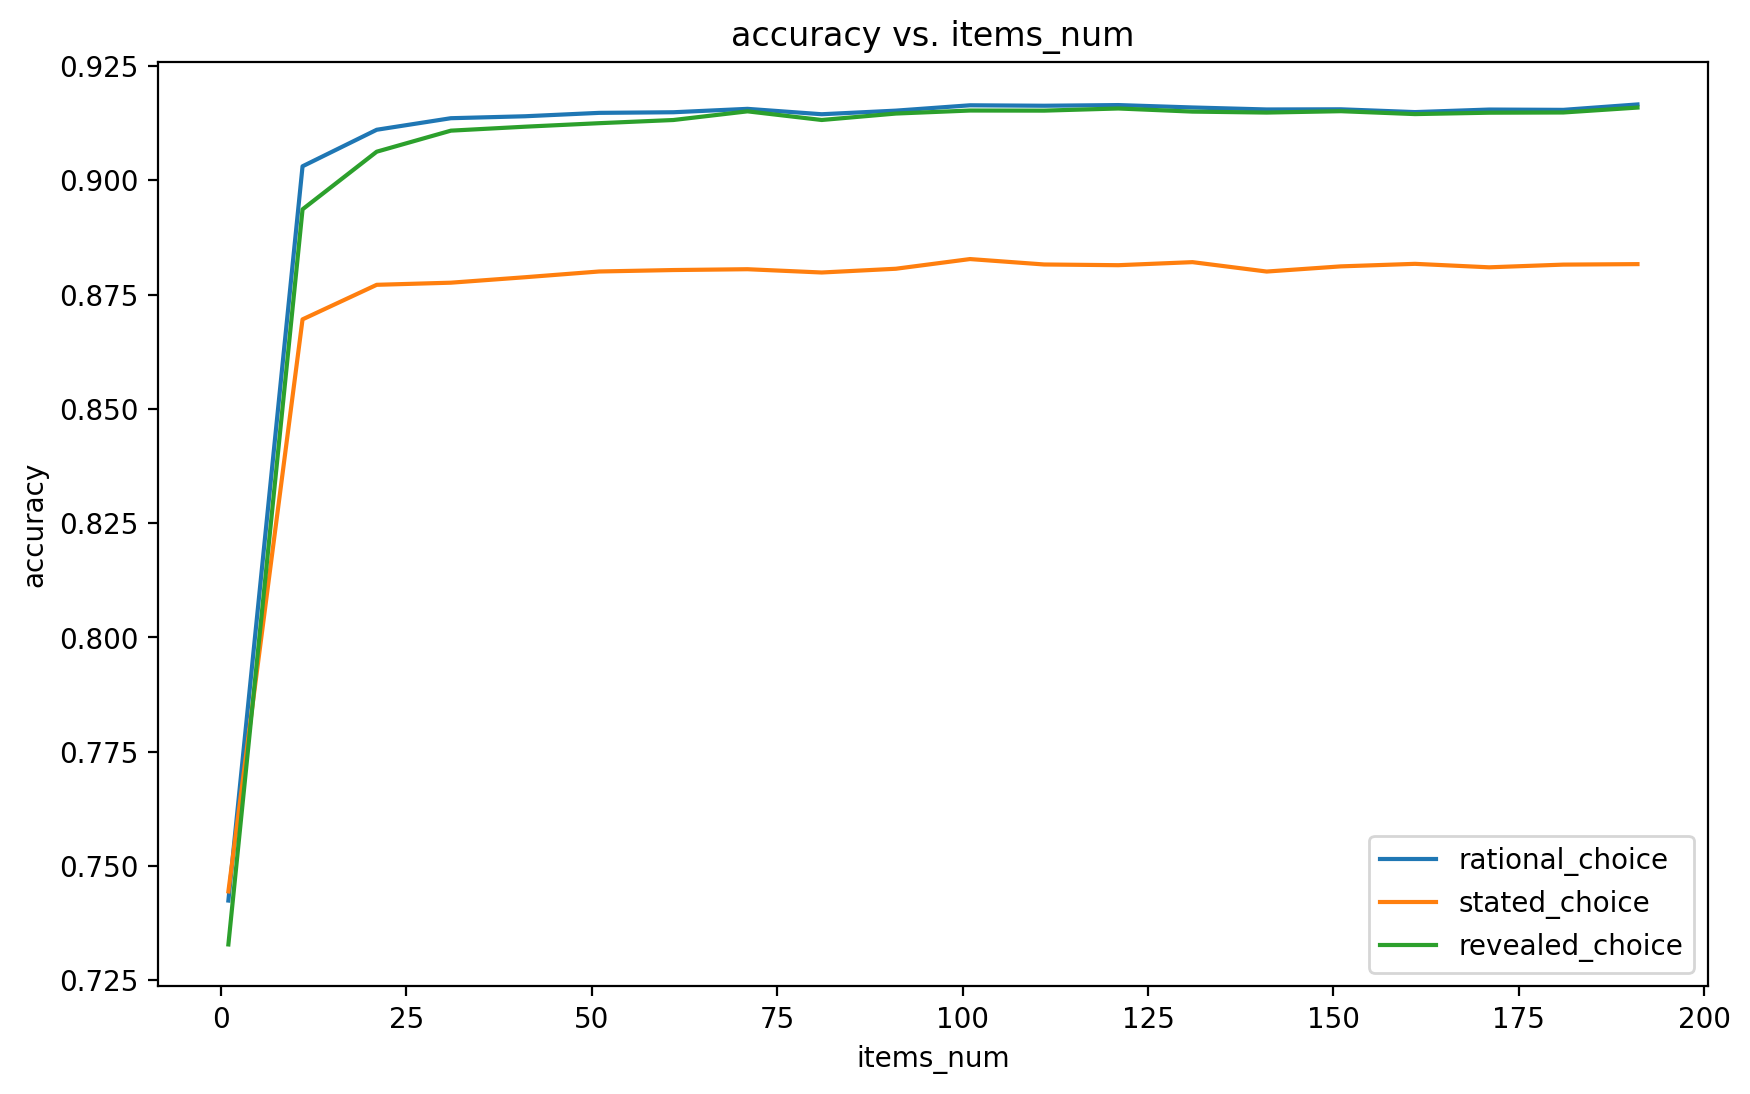

In [22]:
items_num_vec = np.arange(1, 201, 10)
create_graph_for_welfare_param(items_num_vec, 'items_num')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

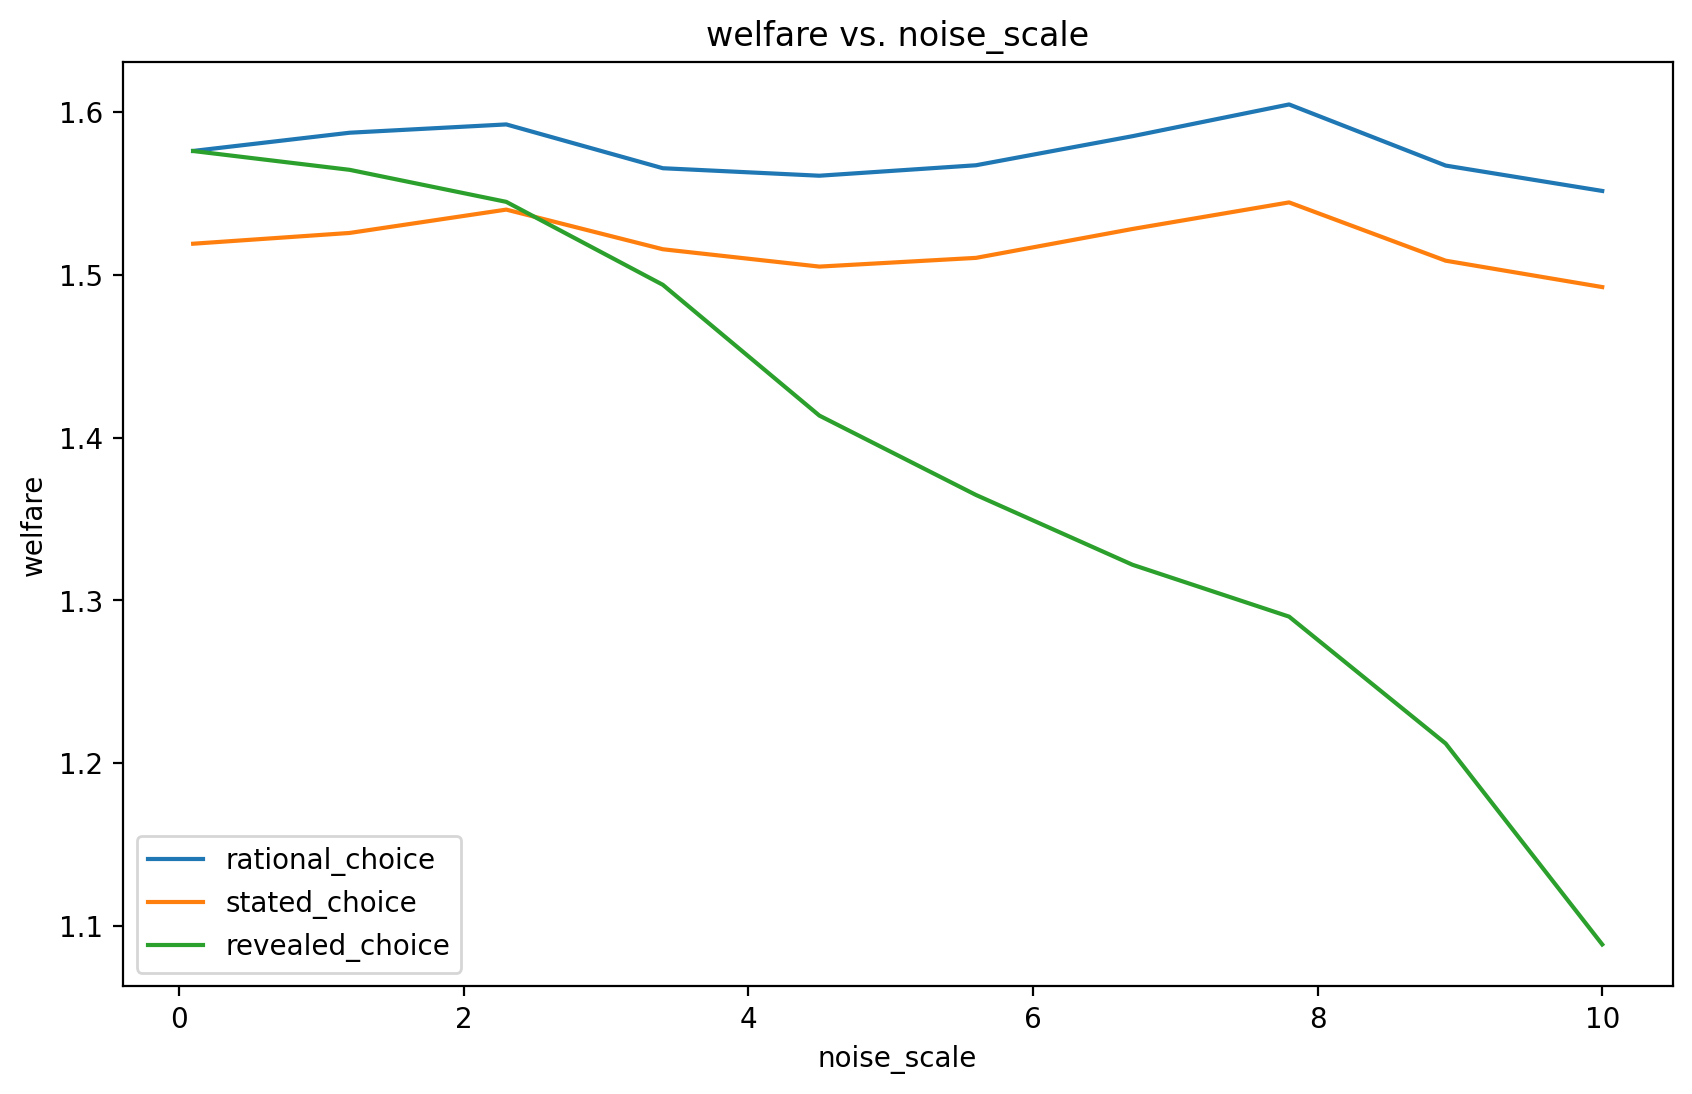

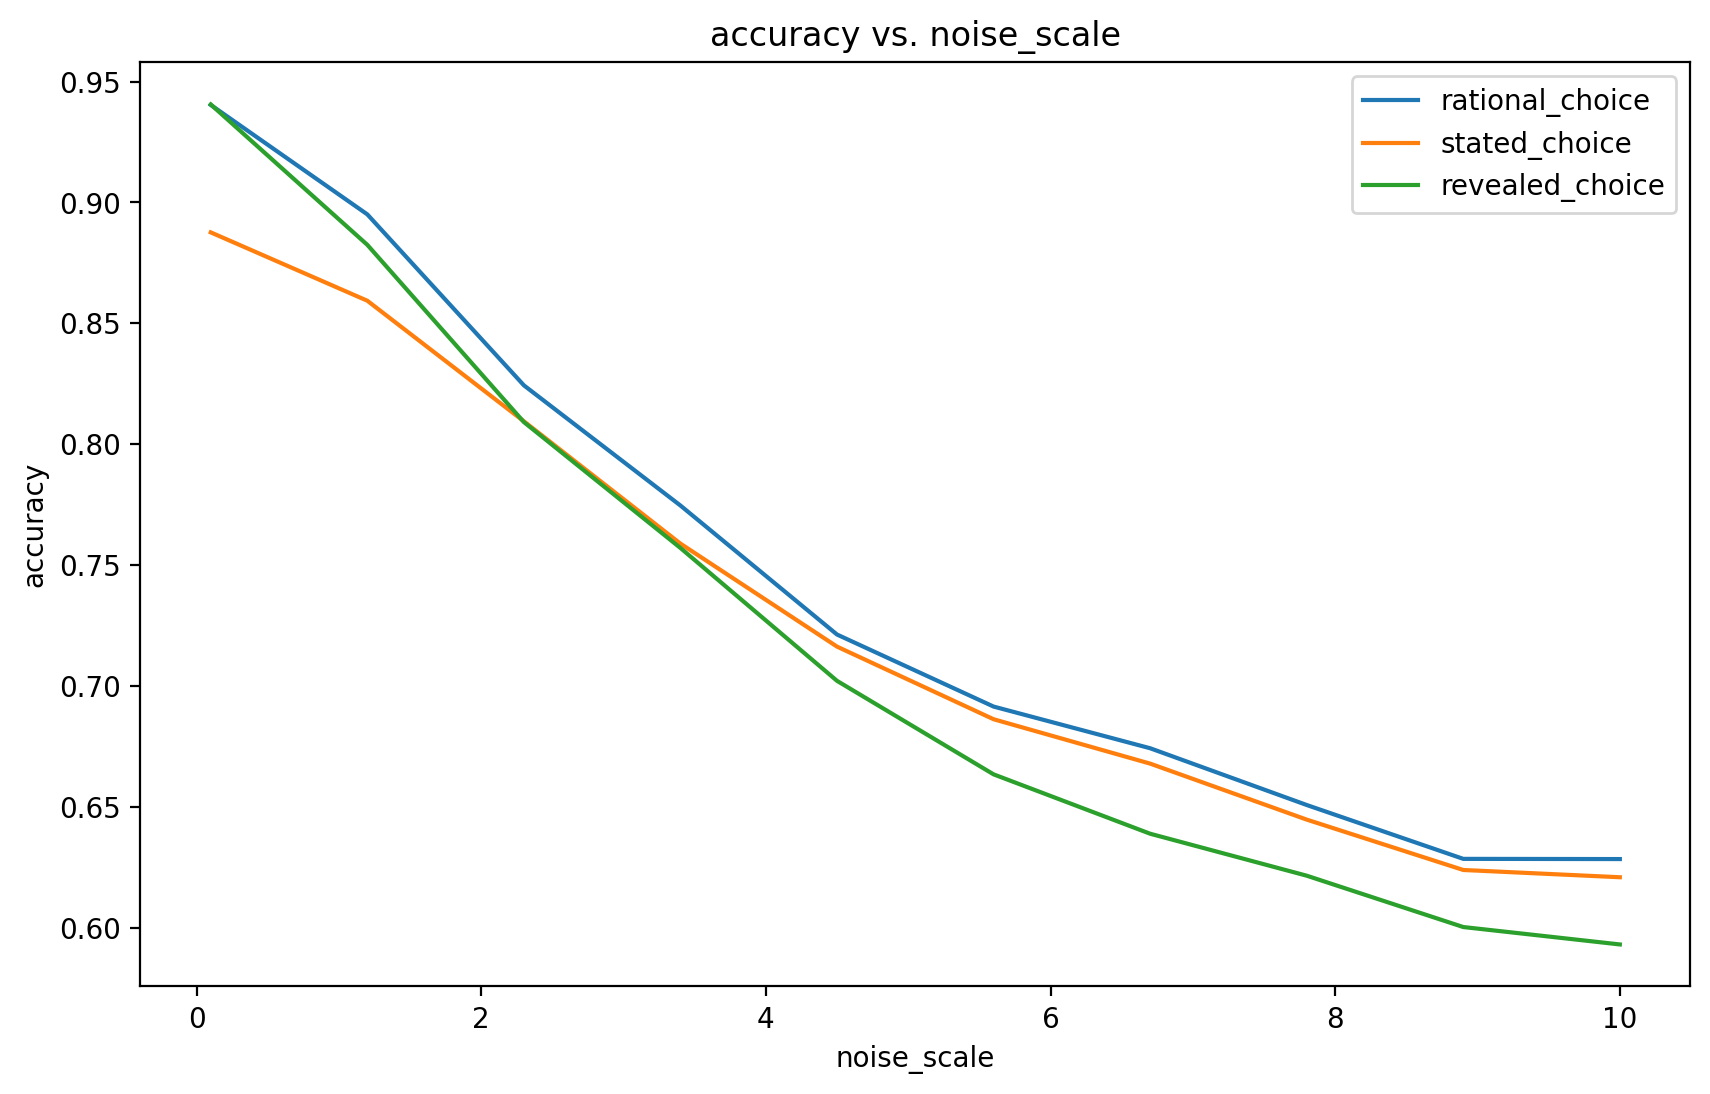

In [23]:
noise_scale_vec = np.linspace(0.1,10,10)
create_graph_for_welfare_param(noise_scale_vec, 'noise_scale')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

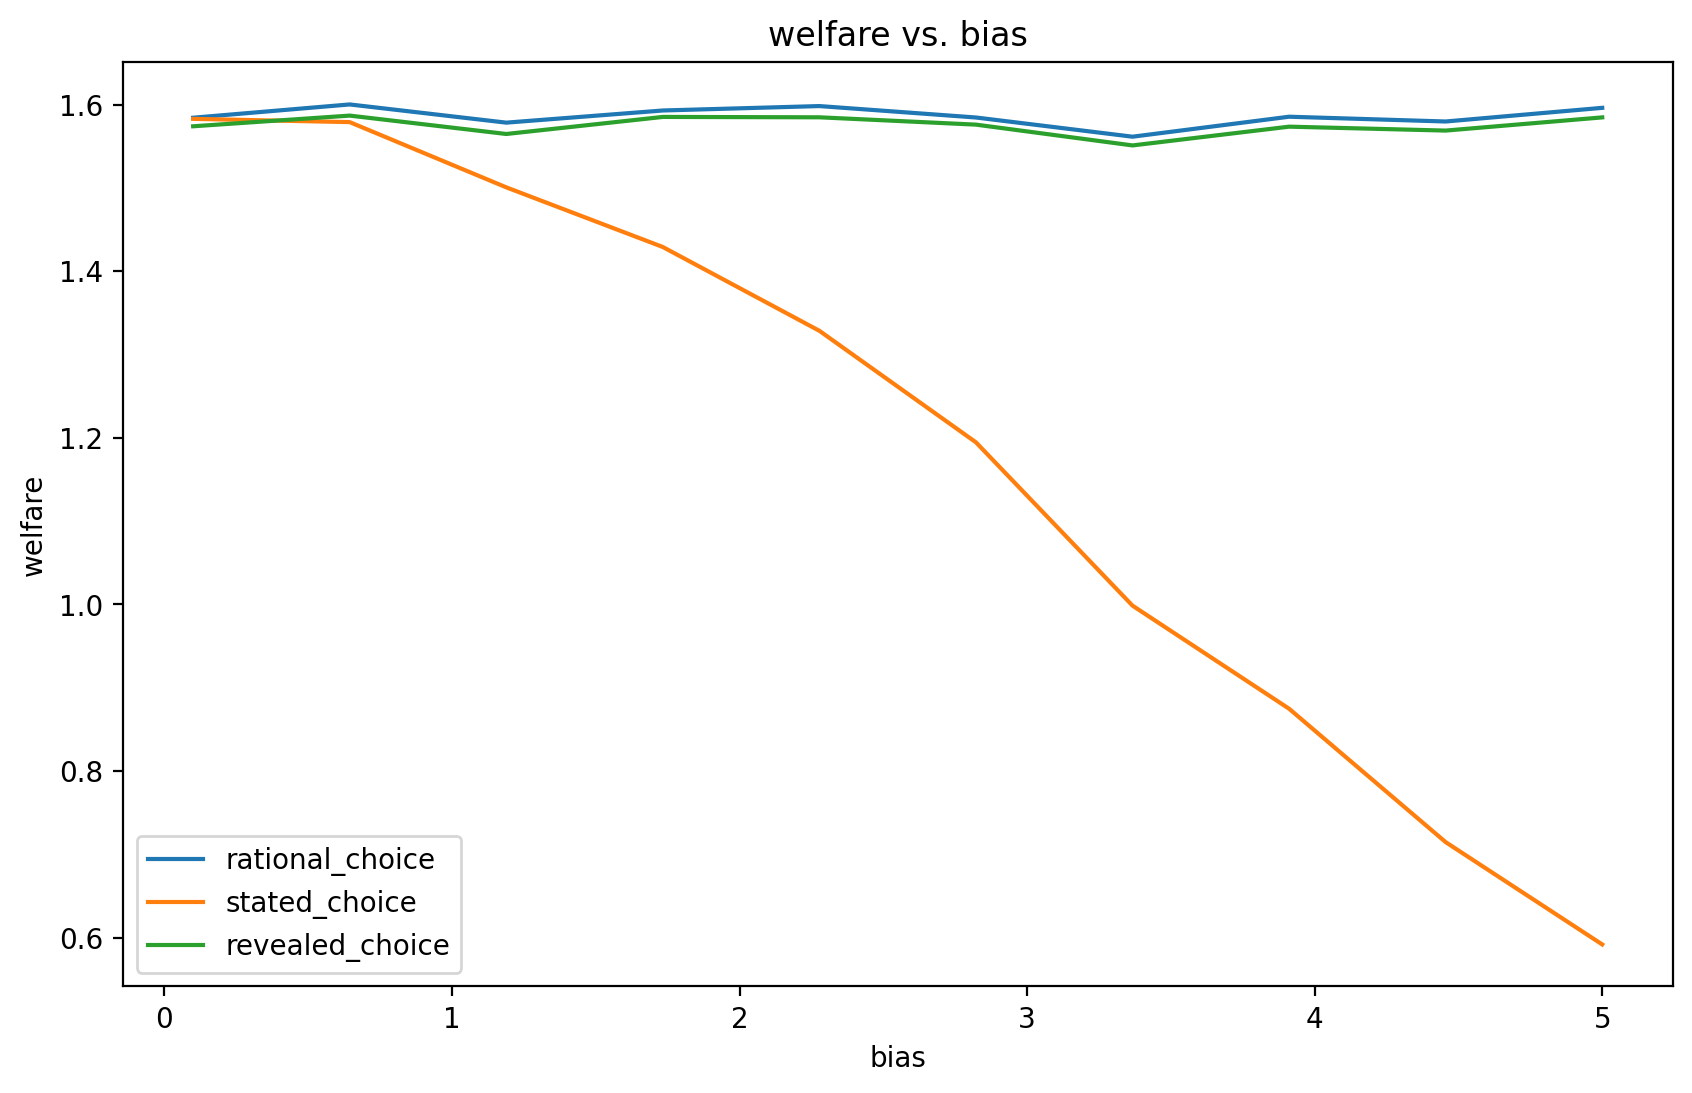

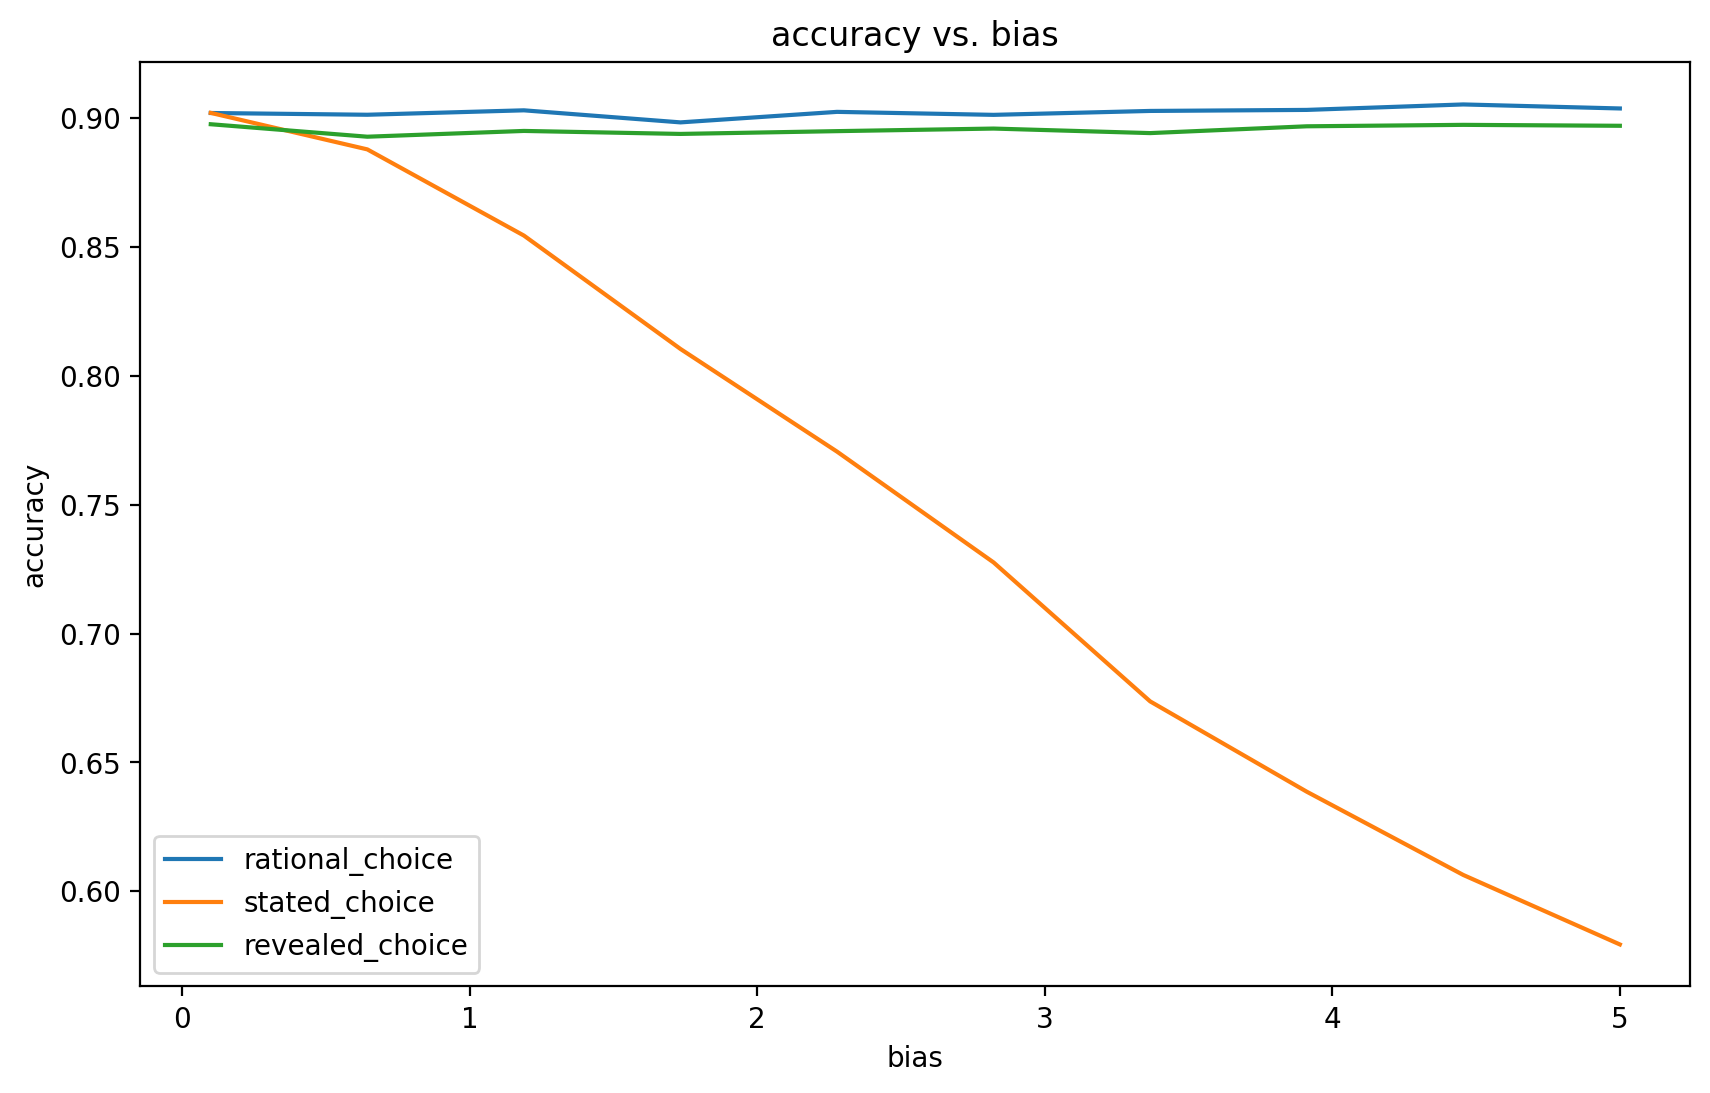

In [24]:
bias_vec = np.linspace(0.1, 5, 10)
create_graph_for_welfare_param(bias_vec, 'bias')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

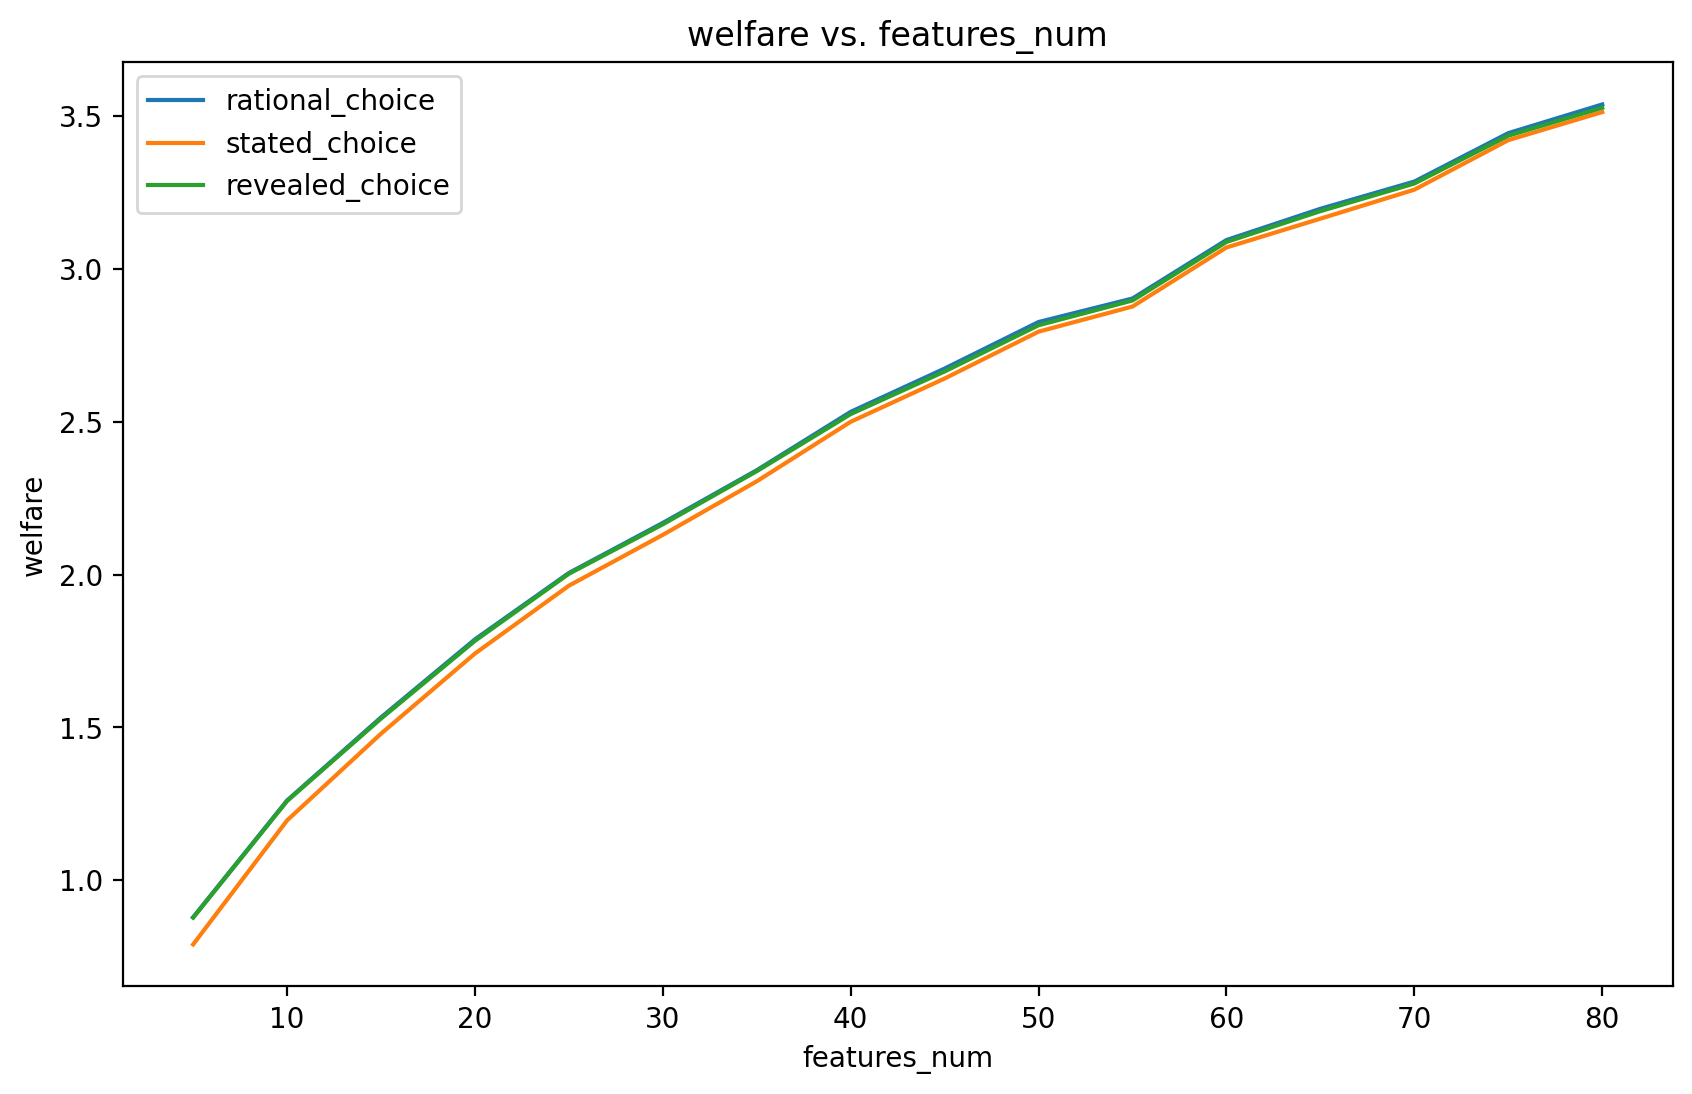

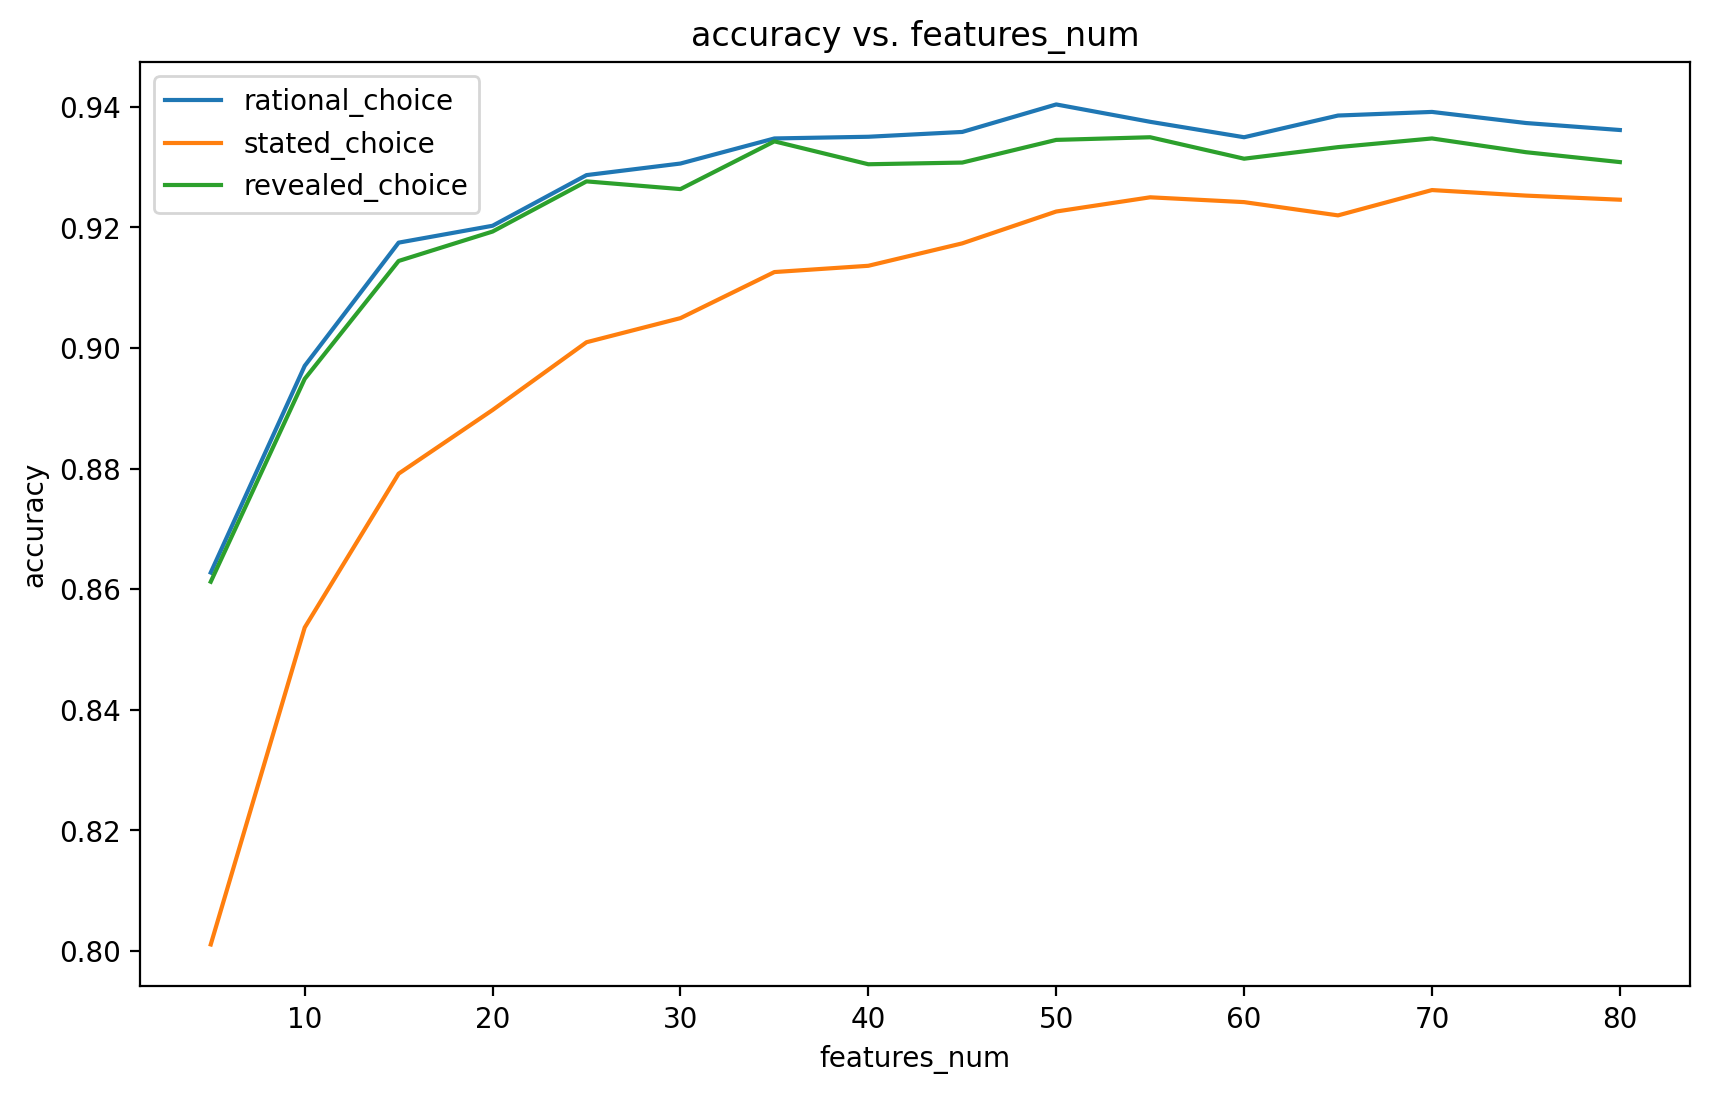

In [25]:
def create_graph_for_welfare_param(param_vec, param_name):
    label_graph_welfare = { label: pd.DataFrame() for label in labels}
    label_graph_accuracy = { label: pd.DataFrame() for label in labels}
    for param in param_vec:
        welfares = { label: [] for label in labels}
        accuracies = { label: [] for label in labels}
        for _ in tqdm(range(50)):
            welfares_for_n_repetitions, accuracies_for_n_repetitions = get_welfare(train_users_num=100, **{param_name: param})
            for label in labels:
                welfares[label].append(welfares_for_n_repetitions[label])
                accuracies[label].append(accuracies_for_n_repetitions[label])
        welfares_mean = {label: np.mean(welfares[label]) for label in labels}
        accuracies_mean = {label: np.mean(accuracies[label]) for label in labels}
        for label in labels:
            label_graph_welfare[label].loc[param, 'welfare'] = welfares_mean[label]
            label_graph_accuracy[label].loc[param, 'accuracy'] = accuracies_mean[label]
    plot_graph(label_graph_welfare, 'welfare', param_name)
    plot_graph(label_graph_accuracy, 'accuracy', param_name)
    
n_features_vec = np.arange(5, 81, 5)
create_graph_for_welfare_param(n_features_vec, 'features_num')

Answer for Option 1:

We wanted to find out how much addition of more data can help recommendation systems when the users act on a noisy choice enviorment. Our prediction was that in any addition of samples, because the labels are prone to noise and bias, then the model will first learn how to generalize well, but after a certain threshold any increment in samples will be neglectible/

We have ploted the values of welfare and accuracy against progression in the following variables:
- number of items/observations per user
- number of users to train on
- number of features
- bias

And so we got 8 new graphs, and in each graph 3 lines matching a different choice type.
The noteworthy trends we found out are:
- The number of users we train on has accuracy and welfare benefit mostly at first and then the improvement for each increment deminishes drastically. This is in line with our theory.
- The number of items acted the same way as the number of users. So, when creating a recommendation system with the noise choice theory in mind, we see that we can tune the model to its practically best accuracy even on a small sample size.
- In the rational and revealed choices, the number of features we get for the items had no clear benefit in the accuracy. Both reached a "sweet spot" around the 20-25 mark and then declined. This can be attributed to the data getting more complex for the amount of samples (user numbers x items number) we get.
- The Welfare increased as the number of features increased, we think this is not due to any noteworthy conclusions, but due to the welfare equaison benefitting from feature vectors with bigger norm values, and this is a side effect of increasing the number of features. This means that a normilazation is important.


## Option 2: Estimating behavioral deviations (for Task \#2)

Assuming neutral $\pi$ ($\pi(p)=p$) and a power S-shaped utility function $v$ (as described in Ex. 2.1), propose a way to estimate the functional parameters $\alpha,\beta,\gamma$ from data. Support your claims using simulated data.



## Option 3: Accounting for behavioral deviations (for Task \#2)

Assuming neutral $\pi$ ($\pi(p)=p$) and a power S-shaped utility function $v$ (as described in Ex. 2.1), improve predictive performance compared to the naive logistic regression baseline.

Support your claims using simulated data, and evaluate performance on behavioral models with parameters $\alpha, \beta, \gamma$ as defined in `prospect_params_lst` above.
Explain your methods. How did you train your model? Why?



## Open-ended question: Solution

Support your claims with data, explain your results, and maintain clarity. You are free to add code and Markdown cells.


🔵 **Answer**:

We chose to answert Option 1, and the answer to it was written after the question.
We also tried answering Q2 but couldn't fully complete it. We decided to hand it also anyway and the attempt at it is covered bellow.

Answer to Q2:
We tried to look at the problem as an optimization problem. We first created a database to test on containing one user with
known alpha,beta,gamma value. 
We then defined a loss function for the task which is a negative log likelihood on the amount of missed classifications, whighted by out confidence in the decision (sigmoid on the utility value).
We tried and didn't get results we are happy with, we thought it is worth sharing anyway.
We think we could get this to work, however because of time constraints we couldn't continue with it.

In [26]:
## YOUR SOLUTION
import scipy.optimize

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def calculate_utility(alpha, beta, gamma, p, u_a, u_b):
    v = PowerLossAversion(alpha, beta, gamma)
    return p*v(u_a) + (1-p)*v(u_b)

# Randomly generate the alpha, beta, gamma values
true_alpha = np.random.uniform(0, 1)
true_beta = np.random.uniform(true_alpha, 1)
true_gamma = np.random.uniform(1, 3)
true_p = np.random.uniform(0, 1)
v = PowerLossAversion(true_alpha, true_beta, true_gamma)
pi = lambda p: p
behavioral_env = BehavioralProspectEnvironment(v, pi)
behavioral_env.set_observation_per_user(100)
train_df, _ = behavioral_env.generate_train_eval_datasets(n_users_train=1)

# We Filter out the rows where u_a and u_b have the same sign, as alpha, beta, gamma won't have any effect on the choice
train_df = train_df[train_df['u_a']*train_df['u_b'] < 0]
print(train_df.count())
print(train_df.head())

# Solve the optimization problem to find the best alpha, beta, gamma values
def loss_func(params, X, y, true_p):
    #negative log likelihood - as we want to maximize the likelihood
    alpha, beta, gamma = params
    utility = calculate_utility(alpha, beta, gamma, true_p, X['u_a'], X['u_b'])
    prob = sigmoid(utility)
    prob = np.clip(prob, 1e-6, 1 - 1e-6)
    likelihood =  y* np.log(prob) + (1-y)*np.log(1-prob)
    return -np.sum(likelihood)

def scalar_loss_func(params, X, y, true_p):
    alpha, beta, gamma = params
    utility = calculate_utility(alpha, beta, gamma, true_p, X['u_a'], X['u_b'])
    # Loss is the sum of utilities for each row we misclassified, weighted by the utility
    return np.sum(np.abs(utility * (np.sign(utility) != y)))
    

constraints = [
    {'type': 'ineq', 'fun': lambda x: x[1] - x[0] - 0.01}  # beta - alpha >= 0
]

bounds = [
    (0.001, 1 - 0.001),      # alpha between 0 and 1
    (0.001, 1 - 0.001),      # beta between 0 and 1
    (1.001, None)    # gamma >= 1
]

np.where(train_df['behavioral_choice'] == True, 1, -1)

initial_guess = [0.1, 0.5, 2]
result = scipy.optimize.minimize(
    scalar_loss_func,
    initial_guess,
    args=(train_df, train_df['behavioral_choice'], true_p),
    constraints=constraints,
    bounds=bounds,
    method='SLSQP',
)
alpha, beta, gamma = result.x
print(f'True alpha: {true_alpha}, True beta: {true_beta}, True gamma: {true_gamma}, True p: {true_p}')
print(f'alpha: {alpha}, beta: {beta}, gamma: {gamma}')




user_id              74
x0                   74
x1                   74
x2                   74
x3                   74
x4                   74
x5                   74
x6                   74
x7                   74
x8                   74
x9                   74
x10                  74
x11                  74
x12                  74
x13                  74
x14                  74
x15                  74
u_a                  74
u_b                  74
behavioral_choice    74
dtype: int64
   user_id        x0        x1        x2        x3        x4        x5  \
1        0 -2.915923  0.448738 -0.695435 -1.924249 -1.113465 -0.554837   
2        0  1.347688 -0.144160 -2.171639  1.825047 -0.772100  0.233642   
3        0 -1.450187 -0.148564  0.256816  3.080476 -0.096122  0.168379   
4        0 -0.186099  0.361175  0.995343  0.476184 -1.130754 -1.284486   
5        0 -0.672581 -0.719424 -0.869825  0.914465 -1.164016  1.970375   

         x6        x7        x8        x9       x10       x11 

Explain your results:

🔵 **Answer**:

(YOUR SOLUTION)